## 0. Set google drive (Important!)

The notebook assumes there is an updated copy of source code available in google drive. The path is proviede below:

In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

working_dir = '/content/drive/My Drive/Capstone/BioCV_Su23/src'
# working_dir = '/content/drive/MyDrive/capstone/BioCV_Su23/src'

os.chdir(working_dir)

Mounted at /content/drive


## 1. Set-up
Install, import, helper functions, including dataloaders and processing functions.


### 1.1 Installation

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets albumentations

# Liveloss plot utility to watch train/validation loss in realtime
!pip install -q livelossplot
!pip install -q onedrivedownloader nibabel google-cloud-storage MedPy

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 112.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.8/151.8 kB 15.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 28.0 MB/s eta 0:00:00


In [ ]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


### 1.2 Imports

In [ ]:
import os
import random

import albumentations as A
import importlib
import joblib
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from datasets import load_dataset
from livelossplot import PlotLosses
from PIL import Image, ImageOps
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from transformers import (MaskFormerForInstanceSegmentation,
                          MaskFormerImageProcessor)
from transformers import MaskFormerConfig, MaskFormerModel
from typing import List

# Local imports
import utils.metrics as metrics
import utils.mri_common as mri

from utils.metrics import MetricName
from utils.data_handler import DataHandler, MriType, StructuralScan
from utils.mri_plotter import MRIPlotter

np.set_printoptions(precision=16)

# add seeding
torch.manual_seed(100)
np.random.seed(100)
random.seed(100)

# import importlib
# import utils.mri_plotter as mrp
# importlib.reload(mrp)
# from utils.mri_plotter import MRIPlotter
# mri_plt = MRIPlotter()


### 1.3 Initializations (important!)

In [ ]:
# this class will handle all actions related to saving and loading files
# by default, downloads files into the runtime but saves training data to the cloud
data_handler = DataHandler()
mri_plt = MRIPlotter()

In [ ]:
# this will dynamically create a new training directory folder with format maskformer/{unix_date}
def create_train_dir_by_date():
  now = str(int( time.time() ))
  return os.path.join("maskformer", now)

In [ ]:
# Training variables:

# generic folder to hold all models generated from maskformer
# train_dir_prefix = create_train_dir_by_date()
train_dir_prefix = "maskformer/keith"
RETRAIN = False

# Load existing model:
LOAD_MODEL = True
model_file_name = "model_all_aug_20epoch_better.pt"
model_train_dir_prefix = "maskformer/keith"

# For predicting val and training dataset
RECALCULATE_TRAIN_METRICS = False
RECALCULATE_VAL_METRICS = False
metrics_dir_prefix = "maskformer/keith"
train_metrics_file_name = "metrics_train_all_aug_20epoch_jul14.joblib"
val_metrics_file_name = "metrics_val_all_aug_20epoch_jul14.joblib"

# Training resolution
#height, width = 163, 193    #original dimensions
#height, width = 489, 579    #3x
height, width = 512, 512
#height, width = 652, 772    #4x
#height, width = 815, 965    #5x
#height, width = 897, 1062   #5.5x
#height, width = 978, 1158   #6x

In [ ]:
# this part will check if the directory already exists and whether the person intends to overwrite the files in that train directory
dir_exists = data_handler.dir_exists(train_dir_prefix=train_dir_prefix)
if dir_exists:
  answer = input(f"Chosen train_dir_prefix {train_dir_prefix} has files stored. \nAre you sure you want to overwrite this folder? Reply YES: ")
  if answer != "YES":
    print("Dynamically creating a new training directory...")
    train_dir_prefix = create_train_dir_by_date()

print(f"\nFiles will be saved using training_dir_prefix: {train_dir_prefix}")

Chosen train_dir_prefix maskformer/keith has files stored. 
Are you sure you want to overwrite this folder? Reply YES: YES

Files will be saved using training_dir_prefix: maskformer/keith


In [ ]:
# this part will check if the directory already exists and whether the person intends to overwrite the files in that metrics directory
dir_exists = data_handler.dir_exists(train_dir_prefix=metrics_dir_prefix)
if dir_exists:
  answer = input(f"Chosen metrics_dir_prefix {metrics_dir_prefix} has files stored. \nAre you sure you want to overwrite this folder? Reply YES: ")
  if answer != "YES":
    print("Dynamically creating a new metrics directory...")
    metrics_dir_prefix = create_train_dir_by_date()

print(f"\nFiles will be saved using metrics_dir_prefix: {metrics_dir_prefix}")

Chosen metrics_dir_prefix maskformer/keith has files stored. 
Are you sure you want to overwrite this folder? Reply YES: YES

Files will be saved using metrics_dir_prefix: maskformer/keith


### 1.4 General functions

In [ ]:
# helper functions
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

def collate_fn(batch):
    return {
            "pixel_values": torch.stack([example["pixel_values"] for example in batch]),
            "pixel_mask": torch.stack([example["pixel_mask"] for example in batch]),
            "class_labels": [example["class_labels"] for example in batch],
            "mask_labels": [example["mask_labels"] for example in batch],
            "subj_no": [example["subj_no"] for example in batch],
            "file_no": [example["file_no"] for example in batch]
            }

# get mask
def scale_mask(mask):
    if isinstance(mask, torch.Tensor):
        visual_mask = (mask.bool().numpy() * 255).astype(np.uint8)
    else:
        visual_mask = (mask * 255).astype(np.uint8)

    return Image.fromarray(visual_mask)

def get_mask(segmentation, segment_id):
  mask = (segmentation.cpu().numpy() == segment_id)
  return scale_mask(mask)

def softmax(logits):
    e_x = np.exp(logits - np.max(logits))
    return e_x / e_x.sum(axis=0)

def softmax_2d(logits):
    e_x = np.exp(logits - np.max(logits, axis=(0, 1), keepdims=True))
    return e_x / np.sum(e_x, axis=(0, 1), keepdims=True)

def denormalize_img(img_data):
    denormalized_image = ( img_data * np.array(ADE_STD)[:, None, None] ) + np.array(ADE_MEAN)[:, None, None]
    denormalized_image = ( denormalized_image * 255 ).astype(np.uint8)
    denormalized_image = np.moveaxis(denormalized_image, 0, -1)
    return denormalized_image

def input_mask_to_segmentation(input_mask_labels, class_labels):
    # map (4,512,512) to segmentation (512, 512)
    input_mask_mapping = {label_id: label_id for label_id in class_labels}
    input_mask_to_segm = np.vectorize(input_mask_mapping.get)(input_mask_labels.argmax(axis=0))
    return input_mask_to_segm

def pred_mask_to_segmentation(results):
    # map results['segmentation'] to correct labels
    # note that mapping is required since maskformer can use a segment value different from the actual label
    # id is not always equal to label id
    # [{'id': 0, 'label_id': 0, 'was_fused': False, 'score': 0.99242},
    # {'id': 1, 'label_id': 2, 'was_fused': False, 'score': 0.889586},
    # {'id': 2, 'label_id': 3, 'was_fused': False, 'score': 0.900965},
    # {'id': 3, 'label_id': 1, 'was_fused': False, 'score': 0.944047}]
    # segmentation result may also have -1. add this to the mapping

    pred_mask_mapping = {info['id']: info['label_id'] for info in results['segments_info']}
    pred_mask_mapping[-1] = -1
    pred_mask_to_segm = np.vectorize(pred_mask_mapping.get)(results['segmentation'])
    return pred_mask_to_segm


def plot_mask_labels(class_labels, pixel_values, mask_labels, title):
    n_image = len(class_labels) + 1

    # plot input pixel values
    fig, axs = plt.subplots(nrows=1, ncols=n_image, figsize=(5*n_image, 5))
    denormalized_img = denormalize_img(pixel_values)
    mri_plt.plot_img(img_data=denormalized_img, title=title, fig=fig, axs=axs, row=0, col=0)

    # plot mask for each label
    for mask_idx, mask_id in enumerate(class_labels):
        visual_mask = scale_mask(mask_labels[mask_idx])
        segment_name = id2label[mask_id]
        mri_plt.plot_img(img_data=visual_mask, title=segment_name, fig=fig, axs=axs, row=0, col=mask_idx+1)

    plt.tight_layout()
    plt.show()

def plot_mask_comparison(class_labels, input_pixel_values, input_mask_labels, pred_mask_labels, title):
    n_image = len(class_labels) + 1

    fig, axs = plt.subplots(nrows=1, ncols=n_image, figsize=(5*n_image, 5))

    denormalized_img = denormalize_img(input_pixel_values)
    mri_plt.plot_img(img_data=denormalized_img, title=title, fig=fig, axs=axs, row=0, col=0)

    for mask_idx, mask_id in enumerate(class_labels):

        axs_idx = mask_idx + 1
        segment_name = id2label[mask_id]

        input_visual_mask = scale_mask(input_mask_labels[mask_idx])
        pred_visual_mask = scale_mask(pred_mask_labels[mask_idx])

        mri_plt.plot_masks(masks=[input_visual_mask, pred_visual_mask],
                           legends=["input", "predicted"],
                           title=segment_name,
                           fig=fig, axs=axs, row=0, col=axs_idx)
    plt.tight_layout()
    plt.show()

def plot_segmentation_comparison(input_pixel_values, input_segmentation, pred_segmentation, title):
    n_image = 3
    fig, axs = plt.subplots(nrows=1, ncols=n_image, figsize=(4*n_image, 4))
    denormalized_img = denormalize_img(input_pixel_values)
    mri_plt.plot_img(img_data=denormalized_img, title=title, fig=fig, axs=axs, row=0, col=0)

    mri_plt.plot_segm_img(img_data=input_segmentation, fig=fig, axs=axs, row=0, col=1, use_legend=True)
    mri_plt.plot_segm_img(img_data=pred_segmentation, fig=fig, axs=axs, row=0, col=2, use_legend=True)

    plt.tight_layout()
    plt.show()

In [ ]:
# Reusable functions
def get_subj_ids(subj_files):
    # get unique subj train ids: [0001, 0002, 0003 ..]
    subj_ids = []
    for subj in subj_files:
        subj_id = data_handler.get_mri_subj_id(subj)
        if subj_id not in subj_ids:
            subj_ids.append(subj_id)
    return subj_ids

def get_subset_files(subj_files, subj_ids):
    # filter files within range
    subj_filenames = []
    for file_name in subj_files:
        subj_id = data_handler.get_mri_subj_id(file_name)
        subj_idx = subj_ids.index(subj_id)
        file_no = data_handler.get_mri_file_no(file_name)
        if file_no >= file_no_min and file_no < file_no_max and subj_idx >= subj_id_min and subj_idx < subj_id_max:

            # example:
            # file_name: UPENN-GBM-00006_11_FLAIR_1.nii.gz
            # result: UPENN-GBM-00006_1.nii.gz
            subj_filename = data_handler.get_mri_slice_file_name(file_name)

            # item has to be unique
            if subj_filename not in subj_filenames:
                subj_filenames.append(subj_filename)
    subj_filenames.sort()
    return subj_filenames


### 1.5 Data loaders
We define here how to organize data into the input format for maskformer

In [ ]:
# Dataloader for the MRI dataset
class CustomMRIDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, data_handler: DataHandler, data_identifier: MriType, data_list: List[str], processor, transform=None, augment=None):
        """
        Args:
            dataset
        """
        # valid types: MriType.TRAIN_2D, MriType.VAL_2D, MriType.TRAIN_2d_CROSS and  MriType.VAL_2D_CROSS
        self.mri_type = data_identifier

        self.processor = processor
        self.transform = transform
        self.augment = augment

        # use the Data Handler class to handle all sorts of image loading
        self.data_handler = data_handler

        self.data_list = data_list.copy()
        self.n_data = len(self.data_list)

    def __len__(self):
        return self.n_data

    def __getitem__(self, idx):

        if idx >= self.n_data:
            print("warning: given index",idx,"does not exist in data. Using firs sample instead.")

        # find a file corresponding to idx
        item = None
        try:
          item = self.data_list[idx]
        except IndexError:
          item = self.data_list[0]

        subj_no = item.split('.')[0].split('_')[0]
        file_no = item.split('.')[0].split('_')[1]
        # print("Subj no", subj_no)
        # print("File no", file_no)
        # load data file to image and instance_seg
        # return nifti=True to return format before converting to numpy get_fdata

        data_cur, data_cur_nifti = self.data_handler.load_mri(subj_id = subj_no, file_no=file_no, mri_type = self.mri_type,
                                              struct_scan = StructuralScan.FLAIR, return_nifti=True)
        # print(data_cur.shape)
        n_h = data_cur_nifti.shape[0]
        n_w = data_cur_nifti.shape[1]
        image = np.zeros( (n_h, n_w, 3) )

        # convert data range from [0 1] to [0 255]
        image[:,:,0] = data_cur * 255
        # print("image mean, max=",image[:,:,0].mean(), image[:,:,0].max())

        data_cur = self.data_handler.load_mri(subj_id = subj_no, file_no=file_no, mri_type = self.mri_type, struct_scan = StructuralScan.T1)
        image[:,:,1] = data_cur * 255

        data_cur = self.data_handler.load_mri(subj_id = subj_no, file_no=file_no, mri_type = self.mri_type, struct_scan = StructuralScan.T1GD)
        image[:,:,2] = data_cur * 255

        # load segm file
        data_cur = self.data_handler.load_mri(subj_id = subj_no, file_no=file_no, mri_type = self.mri_type, dtype="uint8")
        instance_seg =  np.zeros( (n_h, n_w), dtype='uint8')
        instance_seg[:,:] = data_cur
        # print(instance_seg.max())
        # currently set mapping manually
        mapping_dict = {}
        mapping_dict[0] = 0
        mapping_dict[1] = 1
        mapping_dict[2] = 2
        mapping_dict[4] = 3
        # mapping_dict[4] = 4

        # Use NumPy's vectorize() function to apply the mapping function to each element in the original array
        class_id_map = np.vectorize(lambda x: mapping_dict[x])(instance_seg)
        class_labels = np.unique(class_id_map)

        inst2class = {}
        for label in class_labels:
            instance_ids = np.unique(instance_seg[class_id_map == label])
            inst2class.update({i: label for i in instance_ids})

        # apply data augmentation
        if self.augment is True:

            # # Image Color Jittering
            # print("image mean, max=",image[:,:,0].mean(), image[:,:,0].max())
            pil_image = Image.fromarray(image.astype(np.uint8))
            color_jitter = torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
            pil_image = color_jitter(pil_image)
            image = np.array(pil_image)
            # print("image mean, max=",image[:,:,0].mean(), image[:,:,0].max())

            # convert to C, H, W (torchvision transforms assume this shape)
            image = image.transpose(2,0,1)
            n1_tmp = instance_seg.shape[0]
            n2_tmp = instance_seg.shape[1]
            instance_seg = instance_seg.reshape((1,n1_tmp,n2_tmp))

            # convert to tensors
            image = torch.from_numpy(image.astype('float'))
            instance_seg = torch.from_numpy(instance_seg)
            # print("image mean, max=",image[0,:,:].mean(), image[0,:,:].max())

            # Apply random horizontal flip to image and mask
            if np.random.random() > 0.5:
                image = TF.hflip(image)
                instance_seg = TF.hflip(instance_seg)

            # Apply random crop to both the image and mask (as tensors)
            factor1 = 0.8
            if random.random() > 0.2:
                chance1 = random.choice([0,1,2,3,4])
                dim1 = image.shape
                # print('Original image dimension:',dim1,'choice:',chance1)
                if chance1 == 0: #upper left
                    image        =        image[:,:int(dim1[1]*factor1),:int(dim1[2]*factor1)]
                    instance_seg = instance_seg[:,:int(dim1[1]*factor1),:int(dim1[2]*factor1)]
                elif chance1 == 1: #upper right
                    image        =        image[:,:int(dim1[1]*factor1),int(dim1[2]*(1-factor1)):]
                    instance_seg = instance_seg[:,:int(dim1[1]*factor1),int(dim1[2]*(1-factor1)):]
                elif chance1 == 2: #lower right
                    image        =        image[:,int(dim1[1]*(1-factor1)):,int(dim1[2]*(1-factor1)):]
                    instance_seg = instance_seg[:,int(dim1[1]*(1-factor1)):,int(dim1[2]*(1-factor1)):]
                elif chance1 == 3: #lower left
                    image        =        image[:,int(dim1[1]*(1-factor1)):,:int(dim1[2]*factor1)]
                    instance_seg = instance_seg[:,int(dim1[1]*(1-factor1)):,:int(dim1[2]*factor1)]
                else: # center
                    image        =        image[:,int(dim1[1]*(1-factor1)*0.5):int(dim1[1]*(1+factor1)*0.5), \
                                                  int(dim1[2]*(1-factor1)*0.5):int(dim1[2]*(1+factor1)*0.5)]
                    instance_seg = instance_seg[:,int(dim1[1]*(1-factor1)*0.5):int(dim1[1]*(1+factor1)*0.5), \
                                                  int(dim1[2]*(1-factor1)*0.5):int(dim1[2]*(1+factor1)*0.5)]

            #change back to ndarray
            image = image.numpy()
            instance_seg = instance_seg.numpy()
            instance_seg = instance_seg[0,:,:]

            # convert to H, W, C (transform requires this)
            image = image.transpose(1,2,0)
            # print("image mean, min, max=",image[:,:,0].mean(), image[:,:,0].min(), image[:,:,0].max())

            # # remove labels not in the transformed segmentation map
            # inst_remove = {}
            # for instance in inst2class.keys():
            #     if not np.any(np.isin(instance_seg, instance)):
            #         inst_remove[instance] = 0
            # inst2class_new = {k: v for k, v in inst2class.items() if k not in inst_remove}
            # inst2class.update(inst2class_new)

            # # handle possible instance 0 that is created in transform
            # if instance_seg.min() == 0 and 0 not in inst2class:
            #     inst2class[0] = 0

            # print("inst2class after transform  :", inst2class)
            # print("instance_seg after transform:", np.unique(instance_seg))

        # apply input transforms, including resize (after cropping)
        if self.transform:
            transformed = self.transform(image=image, mask=instance_seg)
            # print("image mean, min, max=",image[:,:,0].mean(), image[:,:,0].min(), image[:,:,0].max())
            # print("instance_seg mean, min, max=",instance_seg[:,:].mean(), instance_seg[:,:].min(), instance_seg[:,:].max())

            image, instance_seg = transformed['image'], transformed['mask']
            # print("image mean, min, max=",image[:,:,0].mean(), image[:,:,0].min(), image[:,:,0].max())
            # print("instance_seg mean, min, max=",instance_seg[:,:].mean(), instance_seg[:,:].min(), instance_seg[:,:].max())

        # Prepare data to fit Maskformer input
        # if class_labels.shape[0] == 1 and class_labels[0] == 0:
        #     # Some image does not have annotation (all ignored)
        #     inputs = self.processor([image], return_tensors="pt")
        #     inputs = {k:v.squeeze() for k,v in inputs.items()}
        #     inputs["class_labels"] = torch.tensor([0])
        #     inputs["mask_labels"] = torch.zeros((0, inputs["pixel_values"].shape[-2], inputs["pixel_values"].shape[-1]))
        # else:
        #     inputs = self.processor([image], [instance_seg], instance_id_to_semantic_id=inst2class, return_tensors="pt")
        #     inputs = {k: v.squeeze() if isinstance(v, torch.Tensor) else v[0] for k,v in inputs.items()}
        inputs = self.processor([image], [instance_seg], instance_id_to_semantic_id=inst2class, return_tensors="pt")
        inputs = {k: v.squeeze() if isinstance(v, torch.Tensor) else v[0] for k,v in inputs.items()}

        # add file and subj to input
        inputs["subj_no"] = subj_no
        inputs["file_no"] = file_no

        return inputs


## 2. Process 2D data

### 2.1 load and select data

In [ ]:
# set directories
train_list_full = "data_train_all.txt"
val_list_full   = "data_val_all.txt"
train_list = "data_train.txt"
val_list   = "data_val.txt"

#### Using below if use all data

In [ ]:
# train_2d = data_handler.list_mri_in_dir(mri_type=MriType.TRAIN_2D_CROSS)
# train_files_unique = [data_handler.get_mri_slice_file_name(file_name) for file_name in train_2d]
# train_files_unique = list(set(train_files_unique))
# train_files_unique.sort()
# print(f"Number of unique training samples: {len(train_files_unique)}")
# data_handler.save_text(file_name = train_list,
#                        train_dir_prefix=train_dir_prefix,
#                        data='\n'.join(str(item) for item in train_files_unique))


# val_2d = data_handler.list_mri_in_dir(mri_type=MriType.VAL_2D_CROSS)
# val_files_unique = [data_handler.get_mri_slice_file_name(file_name) for file_name in val_2d]
# val_files_unique = list(set(val_files_unique))
# val_files_unique.sort()
# print(f"Number of unique validation samples: {len(val_files_unique)}")
# data_handler.save_text(file_name = val_list,
#                        train_dir_prefix=train_dir_prefix,
#                        data='\n'.join(str(item) for item in val_files_unique))

#### **Testing:** Using a small portion of data for efficient testing

In [ ]:
# list files
train_2d = data_handler.list_mri_in_dir(mri_type=MriType.TRAIN_2D)
val_2d = data_handler.list_mri_in_dir(mri_type=MriType.VAL_2D)

# save if files do not exist yet
train_file_exists = data_handler.file_exists(train_dir_prefix=train_dir_prefix, file_name = train_list_full)
if not train_file_exists:
    data_handler.save_text(file_name = train_list_full,
                        train_dir_prefix=train_dir_prefix,
                        data='\n'.join(str(item) for item in train_2d))

val_file_exists = data_handler.file_exists(train_dir_prefix=train_dir_prefix, file_name = val_list_full)
if not val_file_exists:
    data_handler.save_text(file_name = val_list_full,
                        train_dir_prefix=train_dir_prefix,
                        data='\n'.join(str(item) for item in val_2d))

100%|██████████| 913M/913M [00:23<00:00, 38.3MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 64241/64241 [00:12<00:00, 5122.98it/s]
100%|██████████| 322M/322M [00:08<00:00, 39.8MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 21901/21901 [00:04<00:00, 5330.56it/s]


In [ ]:
# selecting slice range
n_total = 146
file_no_min = n_total//2 - 20
file_no_max = n_total//2 + 20
#file_no_min = 0
#file_no_max = n_total + 1

# selecting patent id range
subj_total = 88
#subj_id_min = 0
#subj_id_max = 1
subj_id_min = 0
subj_id_max = subj_total + 1

# Define train and validation dataset
# obtain all train subject ids
subj_train_files = data_handler.load_text_as_list(file_name=train_list_full,
                                                  train_dir_prefix=train_dir_prefix)
subj_train_ids = get_subj_ids(subj_train_files)

train_files_unique_c = get_subset_files(subj_train_files, subj_train_ids)
print(f"Number of unique training samples: {len(train_files_unique_c)}")
data_handler.save_text(file_name = train_list,
                       train_dir_prefix=train_dir_prefix,
                       data='\n'.join(str(item) for item in train_files_unique_c))

# do same for validation
subj_val_files = data_handler.load_text_as_list(file_name=val_list_full,
                                                train_dir_prefix=train_dir_prefix)

subj_val_ids = get_subj_ids(subj_val_files)
val_files_unique_c = get_subset_files(subj_val_files, subj_val_ids)
print(f"Number of unique validation samples: {len(val_files_unique_c)}")
data_handler.save_text(file_name = val_list,
                       train_dir_prefix=train_dir_prefix,
                       data='\n'.join(str(item) for item in val_files_unique_c))


Number of unique training samples: 3520
Number of unique validation samples: 1200


### 2.2 Create Custom PyTorch Dataset


In [ ]:
# set maskformer processor
# set do_reduce_label to False. Otherwise, problem with no-labeled data (ignored and causes mismatch of indices)
# processor = MaskFormerImageProcessor(do_reduce_labels=False, ignore_index=255, do_resize=False, do_rescale=False, do_normalize=False)
processor = MaskFormerImageProcessor(do_reduce_labels=False, ignore_index=255, do_resize=False, do_rescale=False, do_normalize=False)

In [ ]:
# create train/validation datasets

# use the same mean and std as training set
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

# define data transoforms
train_transform = A.Compose([
    # A.Resize(width=146, height=193),
    # A.Resize(width=193, height=163),
    A.Resize(width=width, height=height),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

# TODO: delete the code that saves the list into the text file (unless there's a need for keeping a record)
train_data_list = data_handler.load_text_as_list(file_name = train_list, train_dir_prefix=train_dir_prefix)
val_data_list = data_handler.load_text_as_list(file_name = val_list, train_dir_prefix=train_dir_prefix)

# create datasets
# train_dataset = CustomMRIDataset(data_handler=data_handler, data_identifier=MriType.TRAIN_2D, data_list=train_data_list, processor=processor, transform=train_transform, augment=False)
train_dataset = CustomMRIDataset(data_handler=data_handler, data_identifier=MriType.TRAIN_2D, data_list=train_data_list, processor=processor, transform=train_transform, augment=True)
val_dataset = CustomMRIDataset(data_handler=data_handler, data_identifier=MriType.VAL_2D, data_list=val_data_list, processor=processor, transform=train_transform, augment=False)

In [ ]:
# setup data loader
batch_size = 2
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_dataloader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [ ]:
# make label dictionary
id2label = mri.SEGMENTS.copy()
print(id2label)

label2id = {}
for key, value in id2label.items():
    label2id[value] = key
print(label2id)

{0: 'ELSE', 1: 'NCR', 2: 'ED', 3: 'ET'}
{'ELSE': 0, 'NCR': 1, 'ED': 2, 'ET': 3}


### 2.3 QC dataset

In [ ]:
# peek at the train dataset
train_input = train_dataset[120]
for k,v in train_input.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)

print(len(train_dataset))
print(train_input["class_labels"])

pixel_values torch.Size([3, 512, 512])
pixel_mask torch.Size([512, 512])
mask_labels torch.Size([4, 512, 512])
class_labels torch.Size([4])
3520
tensor([0, 1, 2, 3])


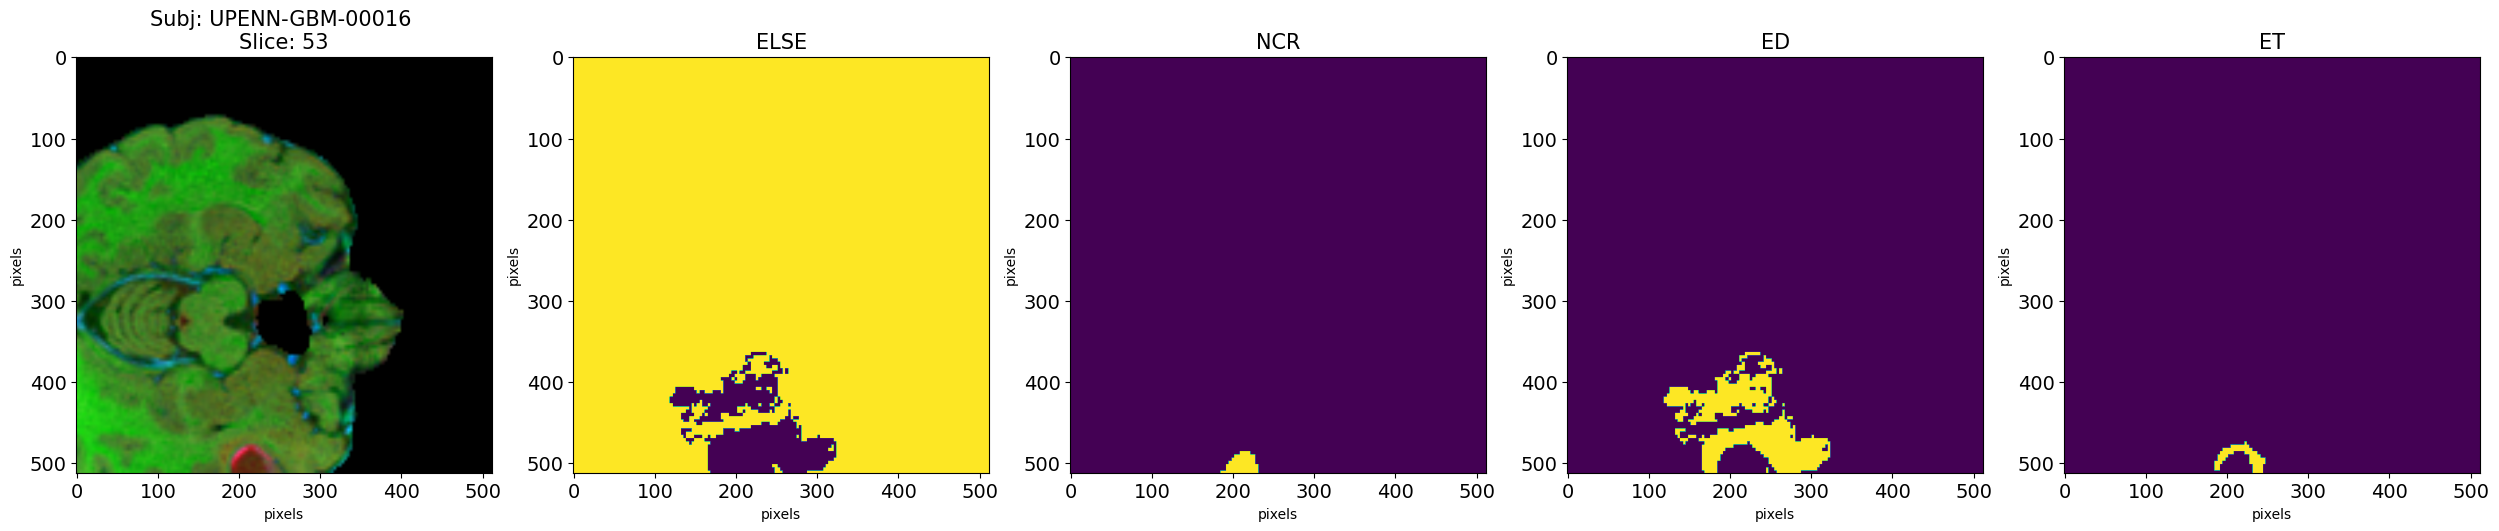

In [ ]:
train_img_title = f"Subj: {train_input['subj_no']} \nSlice: {train_input['file_no']}"
plot_mask_labels(class_labels=train_input["class_labels"].tolist(),
             pixel_values = train_input['pixel_values'].numpy(),
             mask_labels = train_input['mask_labels'],
             title = train_img_title)

In [ ]:
# peek at the val dataset
val_input = val_dataset[119]
for k,v in val_input.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)

print(len(val_dataset))
print(val_input["class_labels"])

pixel_values torch.Size([3, 512, 512])
pixel_mask torch.Size([512, 512])
mask_labels torch.Size([1, 512, 512])
class_labels torch.Size([1])
1200
tensor([0])


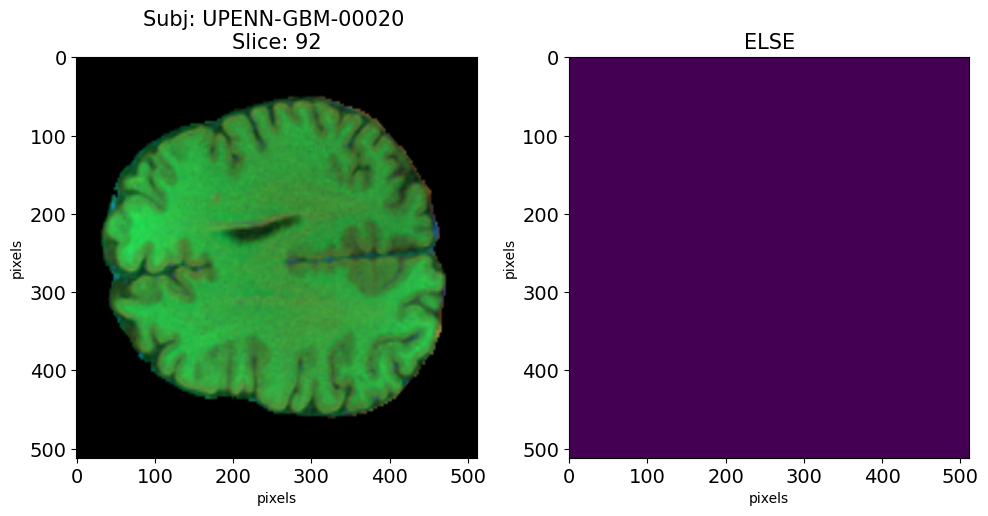

In [ ]:
val_img_title = f"Subj: {val_input['subj_no']} \nSlice: {val_input['file_no']}"

plot_mask_labels(class_labels=val_input["class_labels"].tolist(),
             pixel_values = val_input['pixel_values'].numpy(),
             mask_labels = val_input['mask_labels'],
             title= val_img_title)

## 3. Fine-tuning Model

### 3.1 Define the model

In [ ]:
# load pre-trained maskformer model
# Replace the head of the pre-trained model
# We specify ignore_mismatched_sizes=True to replace the already fine-tuned classification head by a new one
model = MaskFormerForInstanceSegmentation.from_pretrained("zuppif/maskformer-swin-base-ade",
                                                          id2label=id2label,
                                                          label2id=label2id,
                                                          ignore_mismatched_sizes=True)

# define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at zuppif/maskformer-swin-base-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([5]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# load saved model if needed
if LOAD_MODEL == True:
  model_steam = data_handler.load_from_stream(file_name=model_file_name, train_dir_prefix=model_train_dir_prefix)
  model = torch.load(model_steam, map_location=device)

In [ ]:
# add outputs
# model.config.decoder_config.output_attentions = True
# model.config.decoder_config.output_hidden_states = True
# model.config.decoder_config.output_scores = True
model.config.output_attentions = True
# model.config.output_hidden_states = True

# reset weight of losses
# model.config.mask_weight  = 2.0
# model.config.dice_weight = 0.1
# model.config.cross_entropy_weight  = 10000.0
# model.config.use_auxiliary_loss = False
# model.config.ce_weight = 10000.0

# print model config
configuration = model.config
print(configuration)

MaskFormerConfig {
  "_commit_hash": "2414a16c60f1463efcba694a0b4ff6b8a764a4cf",
  "_name_or_path": "zuppif/maskformer-swin-base-ade",
  "architectures": [
    "MaskFormerForInstanceSegmentation"
  ],
  "backbone_config": {
    "_name_or_path": "",
    "add_cross_attention": false,
    "architectures": null,
    "attention_probs_dropout_prob": 0.0,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": null,
    "chunk_size_feed_forward": 0,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "depths": [
      2,
      2,
      18,
      2
    ],
    "diversity_penalty": 0.0,
    "do_sample": false,
    "drop_path_rate": 0.3,
    "early_stopping": false,
    "embed_dim": 128,
    "encoder_no_repeat_ngram_size": 0,
    "encoder_stride": 32,
    "eos_token_id": null,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "hidden_act": "gelu",
 

In [ ]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(batch_size, 3, width, height), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                                                         Input Shape          Output Shape         Param #              Trainable
MaskFormerForInstanceSegmentation (MaskFormerForInstanceSegmentation)                           [2, 3, 512, 512]     [2, 8, 100, 100]     --                   True
├─MaskFormerModel (model)                                                                       [2, 3, 512, 512]     [2, 8, 100, 100]     --                   True
│    └─MaskFormerPixelLevelModule (pixel_level_module)                                          [2, 3, 512, 512]     --                   --                   True
│    │    └─MaskFormerSwinBackbone (encoder)                                                    [2, 3, 512, 512]     [2, 128, 128, 128]   86,882,424           True
│    │    └─MaskFormerPixelDecoder (decoder)                                                    [2, 128, 128, 128]   --                   4,951,808            True
│    └─Mask

The warning is telling us that we're throwing away the classification head and randomly initializing a new one.

### 3.2 Calculate initial loss

Let's take the first batch of the training dataset and forward it through the model, see if we get a loss that makes sense.

This is another trick from [this amazing blog post](http://karpathy.github.io/2019/04/25/recipe/) if you wanna debug your neural networks.

In [ ]:
# obtain a batch of data
batch = next(iter(train_dataloader))

model.to(device)

outputs = model(
        pixel_values=batch["pixel_values"].to(device),
        mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
        class_labels=[labels.to(device) for labels in batch["class_labels"]],
      )
loss_init = outputs.loss.item()

# print basic info
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

# print some info
print([label.shape for label in batch["class_labels"]])
print([label.shape for label in batch["mask_labels"]])

# print loss
print('Initial Loss is:', loss_init)


pixel_values torch.Size([2, 3, 512, 512])
pixel_mask torch.Size([2, 512, 512])
class_labels 2
mask_labels 2
subj_no 2
file_no 2
[torch.Size([2]), torch.Size([4])]
[torch.Size([2, 512, 512]), torch.Size([4, 512, 512])]
Initial Loss is: 0.15165643393993378


### 3.3 Train the model

In [ ]:
if RETRAIN:
    liveloss = PlotLosses()

    batch_max = 100000
    loss_train = []
    loss_val = []
    min_loss = 1e9
    # mutiplier is used to scale loss values to be more readable
    loss_multiplier = 10.0

    # define number of epochs in training
    n_epoch = 10

    # saving model half way
    SAVE_INT = n_epoch // n_epoch

    # define learning rate
    # lr = 2e-5
    lr = 1e-5
    # lr = 0.5e-5

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print( 'Initial loss is {:10.6f}.'.format(round(loss_init, 6)*loss_multiplier) )
    logs = {}
    # logs['loss'] = loss_init
    # logs['val_loss'] = loss_init

    # liveloss.update(logs)
    # liveloss.send()

    for epoch in range(1,n_epoch+1):
        print("Starting Epoch:", epoch)

        ## training loop
        running_loss = 0.0
        num_samples = 0
        model.train()
        for ibatch, batch in enumerate(tqdm(train_dataloader)):
            # run partial data based on input limit
            if ibatch < batch_max:
                # Reset the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(
                        pixel_values=batch["pixel_values"].to(device),
                        mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
                        class_labels=[labels.to(device) for labels in batch["class_labels"]],
                )

                # Backward propagation
                loss = outputs.loss * loss_multiplier
                loss.backward()

                batch_size = batch["pixel_values"].size(0)
                running_loss += loss.item()
                num_samples += batch_size
                loss_train_cur = running_loss/num_samples

                # Optimization
                optimizer.step()
            else:
                # skip where ibatch >= batch_max
                break

        # record loss at the end of each epoch
        logs['loss'] = loss_train_cur
        print( 'Epoch {:<4} training loss is: {:8.6f}.'.format(epoch, round(loss_train_cur, 6)) )
        loss_train.append(loss_train_cur)

        ## validation loop
        running_loss = 0.0
        num_samples = 0
        model.eval()
        with torch.no_grad():
            for ibatch, batch in enumerate(tqdm(val_dataloader)):
                # run partial data based on input limit
                if ibatch < batch_max:
                    # Forward pass
                    outputs = model(
                            pixel_values=batch["pixel_values"].to(device),
                            mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
                            class_labels=[labels.to(device) for labels in batch["class_labels"]],
                    )

                    # loss
                    loss = outputs.loss  * loss_multiplier

                    batch_size = batch["pixel_values"].size(0)
                    running_loss += loss.item()
                    num_samples += batch_size
                    loss_val_cur = running_loss/num_samples
                else:
                    # skip where ibatch >= batch_max
                    break

        # record loss at the end of each epoch
        logs['val_loss'] = loss_val_cur
        # print( 'Epoch {:<4} validation loss is: {:8.6f}.'.format(epoch, round(loss_val_cur, 6)) )
        loss_val.append(loss_val_cur)

        # if found better model, update min_loss and save model (currently using training loss)

        if min_loss > loss_val_cur:
            print("Saved model in epoch",epoch)
            # save the best model
            # data_handler.save_torch_model(file_name="model_current.pt", train_dir_prefix=train_dir_prefix, model=model)
            min_loss = loss_val_cur

        # save model regularly
        if epoch%SAVE_INT == 0:
            print("Saved model in epoch",epoch)

            # save the best model
            data_handler.save_torch_model(file_name='model_epoch'+str(epoch)+'.pt', train_dir_prefix=train_dir_prefix, model=model)

        # Update the plot with new logging information.
        liveloss.update(logs)
        liveloss.send()

    # save loss at the end
    data_handler.save_torch_model(file_name='losses_train_current.pt', train_dir_prefix=train_dir_prefix, model=loss_train)
    data_handler.save_torch_model(file_name='losses_val_current.pt', train_dir_prefix=train_dir_prefix, model=loss_val)

## 4. Evaluation

### 4.0 Evaluation Constants and Functions

#### 4.0.1 Prediction Functions

In [ ]:
label_ids = list(id2label.keys())
label_ids.sort()
print("label ids", label_ids)

all_label_names = list(id2label.values())
print("label names", all_label_names)

label ids [0, 1, 2, 3]
label names ['ELSE', 'NCR', 'ED', 'ET']


In [ ]:
def get_2d_slices(file_list, subj):
    # if substring/subj is in the filename, include that file in the list of slices
    vol_list = [file_name for file_name in file_list if subj in file_name]

    # sort the list according to slice number
    vol_list_sorted = sorted(vol_list, key=lambda x: int(x.split('_')[1].split('.')[0]))
    return vol_list_sorted

In [ ]:
def get_mask_from_segm(infer_results, data_id):
    pred_class_labels = set([item["label_id"] for item in infer_results['segments_info']])
    pred_class_labels = sorted(list(pred_class_labels))

    pred_mask_shape = (len(pred_class_labels), infer_results['segmentation'].shape[0], infer_results['segmentation'].shape[1])
    pred_mask_labels = np.zeros(pred_mask_shape, dtype=np.uint8)

    # get predicted mask for each segment
    for mask_idx, mask_id in enumerate(pred_class_labels):
        mask_pred_2d = np.zeros((pred_mask_shape[1], pred_mask_shape[2]), dtype=np.uint8)

        # find predicted masks in results
        for item in infer_results['segments_info']:
            if item['label_id'] == mask_id:
                # get mask will scale to 255
                mask_pred_2d += np.array( get_mask(infer_results['segmentation'], item['id']) )

        mask_pred_2d = mask_pred_2d.astype(np.uint8)
        pred_mask_labels[mask_idx, :, :] = mask_pred_2d

    # output is predicted mask with shape: (n, 512, 512)
    return pred_mask_labels


def predict_3d_mask(model, data_handler, vol_slices_list, processor, transform, identifier=MriType.VAL_2D):

    num_slices = len(vol_slices_list)

    # define a new dataset
    metric_dataset = CustomMRIDataset(data_handler=data_handler, data_identifier=identifier,
                                            data_list=vol_slices_list, processor=processor,
                                            transform=transform, augment=False)

    # define data loader
    batch_size_metrics = 1
    metric_dataloader = DataLoader(metric_dataset, batch_size=batch_size_metrics,
                                      shuffle=False, collate_fn=collate_fn)

    # initalize 3d variables using shape of first input
    first_img_shape = metric_dataset[0]["pixel_values"].shape

    # image_3d: (146, 3, 512, 512)
    image_3d = np.zeros((num_slices, first_img_shape[0], first_img_shape[1], first_img_shape[2]), dtype=np.uint8)

    # fixed number of segments = 4
    # true and predicted masks: (4, 146, 512, 512)
    label_ids = list(mri.SEGMENTS.keys())
    mask_shape_3d = (len(label_ids), num_slices, first_img_shape[1], first_img_shape[2])
    mask_pred_3d = np.zeros(mask_shape_3d, dtype=np.uint8)
    mask_true_3d = np.zeros(mask_shape_3d, dtype=np.uint8)

    # perform prediction
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    model.eval()
    with torch.no_grad():
        for ibatch, batch in enumerate(metric_dataloader):

            # forward pass
            output_cur = model(
                    pixel_values=batch["pixel_values"].to(device),
                    mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
                    class_labels=[labels.to(device) for labels in batch["class_labels"]],
            )

            # get first item in batch where batch size = 1
            image_cur = batch["pixel_values"][0]
            image_3d[ibatch, :, :, :] = image_cur.numpy()

            # post-processing/inference
            result_cur = processor.post_process_instance_segmentation(output_cur,
                                                                      target_sizes=[transforms.ToPILImage()(image_cur).size[::-1]])[0]
            data_id =  batch["subj_no"][0] + "_" + batch["file_no"][0]

            # e.g. (n, 512, 512) where n is the number of existing labels in the prediction
            pred_class_labels = set([item["label_id"] for item in result_cur['segments_info']])
            pred_class_labels = sorted(list(pred_class_labels))

            mask_2d_shape = (len(pred_class_labels), mask_shape_3d[2], mask_shape_3d[3])
            pred_mask_labels = get_mask_from_segm(infer_results=result_cur, data_id=data_id)

            # build mask_pred_3d:
            for mask_idx, label in enumerate(pred_class_labels):
                mask_pred_3d[label, ibatch, :, :] = pred_mask_labels[mask_idx, :, :]

            # obtain true mask where available
            true_mask_labels = batch["mask_labels"][0]
            true_class_labels = batch["class_labels"][0]
            for mask_idx, label in enumerate(true_class_labels):
                mask_true_3d[label, ibatch, :, :] = (true_mask_labels[mask_idx,:,:].bool().numpy() * 255).astype(np.uint8)

    return image_3d, mask_true_3d, mask_pred_3d

#### 4.0.2 Evaluation Functions

In [ ]:
def calc_metric_all_segments(label_ids, metric_func, mask_pred_3d, mask_true_3d):
    results = []
    for label_id in label_ids:
      true_mask_cur = mask_true_3d[label_id,:,:,:].squeeze()
      pred_mask_cur = mask_pred_3d[label_id,:,:,:].squeeze()
      result = metric_func(pred_mask_cur, true_mask_cur)
      results.append(result)
    return results

In [ ]:
def predict_dataset(subj_file_names, subj_selected, data_identifier=MriType.VAL_2D):
    all_dice = []
    all_hd95 = []
    all_common_metrics = []
    error_files = []

    start = time.time()

    image_3d, mask_true_3d, mask_pred_3d = None, None, None

    for subj in subj_selected:

        print("Calculating metrics for ", subj)

        vol_slices_list = get_2d_slices(subj_file_names, subj)

        # 3d mask for a 1 subj
        image_3d, mask_true_3d, mask_pred_3d = predict_3d_mask(model, data_handler, vol_slices_list,
                                                            processor, train_transform, data_identifier)

        mask_pred_3d_binary = (np.array(mask_pred_3d)/255).astype(np.uint8)
        mask_true_3d_binary = (np.array(mask_true_3d)/255).astype(np.uint8)

        try:
            # dice coefficient
            # output array of dice score for all segments: [0.9, 0.8, 0.92, 0.3]
            dice_score = calc_metric_all_segments(label_ids, metrics.calc_dice_score, mask_pred_3d_binary, mask_true_3d_binary)

            # 95% hausdorff distance
            # output array of hd95 for all segments: [5.3, 2.8, 3.92, 1]
            hausdorff_val = calc_metric_all_segments(label_ids, metrics.calc_hausdorff_95, mask_pred_3d_binary, mask_true_3d_binary)

            # common metrics
            # e.g. 'true_positive': [20927582, 148267, 687623, 226880]
            common_metrics = calc_metric_all_segments(label_ids, metrics.calc_binary_metrics, mask_pred_3d_binary, mask_true_3d_binary)
            common_metrics_dict = {}
            for key in common_metrics[0]:
                common_metrics_dict[key] = [metric[key] for metric in common_metrics]

            # append only when there is no error
            all_dice.append(dice_score)
            all_hd95.append(hausdorff_val)
            all_common_metrics.append(common_metrics_dict)

        except Exception as ex:
            print(f"Error {subj}", ex)
            error_files.append(subj)

    end = time.time()
    print("elapsed time", str(end - start))

    return  all_dice, all_hd95, all_common_metrics, error_files

In [ ]:
def predict_and_eval(subj_file_names, subj_names, metrics_dir_prefix=None,
                     metrics_file_name=None, data_identifier=MriType.VAL_2D, recalculate=False):
    metrics_dict = {}
    all_dice = []
    all_hd95 = []
    all_common_metrics = []
    error_files = []

    metrics_dict = {}
    if recalculate:


            all_dice, all_hd95, all_common_metrics, error_files = predict_dataset(subj_file_names, subj_names, data_identifier)

            print("Files with error:", error_files)

            # remove files with error
            success_files = list(filter(lambda x: x not in error_files, subj_names))
            print(f"No. of files after removing problematic images: {len(success_files)}")

            metrics_dict = {'success_files': success_files,
                            'error_files': error_files,
                            'all_dice': all_dice,
                            'all_hd95': all_hd95,
                            'all_common_metrics': all_common_metrics}

            # dump results to temp file
            metrics_temp_file = data_handler.create_temp_file(metrics_file_name)
            joblib.dump(metrics_dict, metrics_temp_file)

            # upload to cloud
            data_handler.save_from_source_path(file_name=metrics_file_name, source_path=metrics_temp_file,
                                            train_dir_prefix=metrics_dir_prefix, use_cloud=True)
    else:
        # load metrics from file instead
        metrics_temp_file = data_handler.load_to_temp_file(file_name=metrics_file_name,
                                                        train_dir_prefix=metrics_dir_prefix)

        metrics_dict = joblib.load(metrics_temp_file)
        success_files = metrics_dict["success_files"]
        print("Files with error:", metrics_dict["error_files"])
        print(f"No. of files: {len(success_files)}")

    # replace None or np.inf values with highest hd95
    all_hd95 = metrics_dict["all_hd95"]
    max_value = 0
    none_indices = []
    for subj_idx, hd95_per_subj in enumerate(all_hd95):
        for segm_idx, hd95 in enumerate(hd95_per_subj):
            if hd95 is None or hd95 == np.inf:
                none_indices.append((subj_idx, segm_idx))
            else:
                if hd95 > max_value:
                    max_value = hd95

    print("max hausdorff", str(max_value))
    print("indices with invalid hd95", str(none_indices))

    # replace the invalid values with max hd value
    for row, col in none_indices:
        metrics_dict["all_hd95"][row][col] = max_value + 1

    # combine all data in one dictionary and convert everything to a numpy array
    # the use of Enum is to avoid typos: MetricName.PRECISION.value = "precision"
    summary_metrics_dict = {
        MetricName.PRECISION.value: np.array([metric[MetricName.PRECISION.value] for metric in metrics_dict["all_common_metrics"]]),
        MetricName.RECALL.value: np.array([metric[MetricName.RECALL.value] for metric in metrics_dict["all_common_metrics"]]),
        MetricName.SENSITIVITY.value: np.array([metric[MetricName.SENSITIVITY.value] for metric in metrics_dict["all_common_metrics"]]),
        MetricName.SPECIFICITY.value: np.array([metric[MetricName.SPECIFICITY.value] for metric in metrics_dict["all_common_metrics"]]),
        MetricName.DICE_SCORE.value: np.array(metrics_dict["all_dice"]),
        MetricName.HD95.value: np.array(all_hd95)
    }

    return summary_metrics_dict, metrics_dict["error_files"], metrics_dict["success_files"]

In [ ]:
def display_statistics(metric_scores, metric_name, label_names):
    print("Summary:", metric_name)
    df = pd.DataFrame(metric_scores, columns=label_names)
    print(df.describe())

In [ ]:
def draw_box_plots(metrics_dict, set_ylim=False):
    nrows = 3
    ncols = 2

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))

    count = 0
    for metric_name, metric_scores in metrics_dict.items():
        row = count//ncols
        col = count%ncols
        ax = axs[row, col]

        sns.boxplot(data=metric_scores,  palette=mri.SEGMENT_COLORS.values(), ax=ax)
        ax.set_xticks(range(len(all_label_names)), all_label_names)
        ax.set_ylabel("score")
        ax.set_title(metric_name)
        if set_ylim:
            ax.set_ylim(0, 1.02)

        count+=1
        ax.grid(True)

    plt.show()

In [ ]:
def build_histogram(metrics_dict):
    nrows = 3
    ncols = 2

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 14))

    count = 0

    # for each metric
    for metric_name, scores in metrics_dict.items():
        row = count//ncols
        col = count%ncols
        ax = axs[row, col]

        x0 = scores[:, 0]
        x2 = scores[:, 1]
        x3 = scores[:, 2]
        x4 = scores[:, 3]
        ax.hist([x0, x2, x3, x4], bins = 20, label=all_label_names, color=mri.SEGMENT_COLORS.values())
        ax.legend()
        ax.set_xlabel(metric_name)
        ax.set_ylabel('count')
        ax.grid(True)
        count+=1
    plt.show()


In [ ]:
def get_low_dice_score_images(subj_list, summary_metrics_dict, top_n=10):
    flattened_array = summary_metrics_dict[MetricName.DICE_SCORE.value].flatten()

    # rearranges the elements such that the smallest n elements come before the nth index
    top_n_idx_1d = np.argpartition(flattened_array, kth=top_n)[:top_n]

    # map the 1d indices to their corresponding 2D indices to match with the correct row (dataset_idx) and col (label_id affected)
    top_n_indices = np.unravel_index(top_n_idx_1d, summary_metrics_dict[MetricName.DICE_SCORE.value].shape)

    # use the indices to retrieve the actual values
    top_n_worst_scores = summary_metrics_dict[MetricName.DICE_SCORE.value][top_n_indices]
    dataset_idx = top_n_indices[0]
    label_id = top_n_indices[1]
    subj_names = np.array(subj_list)[dataset_idx]

    # create a dictionary
    top_n_worst_dice= []
    for subject, dataset_idx, label_id, score in zip(subj_names, dataset_idx, label_id, top_n_worst_scores):
        top_n_worst_dice.append(
            {
                'subj_name': subject,
                'dataset_idx': dataset_idx,
                'label_id': label_id,
                'score': score
            })

    # sort and convert to dataframe
    top_n_worst_dice_sorted = sorted(top_n_worst_dice, key=lambda x: x['score'])
    return pd.DataFrame(top_n_worst_dice_sorted)

In [ ]:
def get_high_hd95_images(subj_list, summary_metrics_dict, top_n=10):
    flattened_array = summary_metrics_dict[MetricName.HD95.value].flatten()

    # rearranges the elements such that the smallest n elements come before the nth index
    top_n_idx_1d = np.argpartition(flattened_array, kth=(-1*top_n))[(-1*top_n):]

    # map the 1d indices to their corresponding 2D indices to match with the correct row (dataset_idx) and col (label_id affected)
    top_n_indices = np.unravel_index(top_n_idx_1d, summary_metrics_dict[MetricName.HD95.value].shape)

    # use the indices to retrieve the actual values
    top_n_worst_scores = summary_metrics_dict[MetricName.HD95.value][top_n_indices]
    dataset_idx = top_n_indices[0]
    label_id = top_n_indices[1]
    subj_names = np.array(subj_list)[dataset_idx]

    top_n_worst_hd95= []
    for subject, dataset_idx, label_id, score in zip(subj_names, dataset_idx, label_id, top_n_worst_scores):
        top_n_worst_hd95.append(
            {
                'subj_name': subject,
                'dataset_idx': dataset_idx,
                'label_id': label_id,
                'score': score
            })
    top_n_worst_hd95_sorted = sorted(top_n_worst_hd95, key=lambda x: (-1*x['score']))
    return pd.DataFrame(top_n_worst_hd95_sorted)

### 4.1 Model prediction QC on one sample



#### 4.1.1 Model prediction and visualization on one sample

In [ ]:
# create a test data loader without shuffling
QC_TYPE = 'val'
batch_size = 2
if QC_TYPE == 'train':
    qc_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
else:
    qc_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [ ]:
# obtain one batch of data
target_batch = 59
for ibatch, batch in enumerate(qc_dataloader):
    if ibatch == target_batch:
        test_batch = batch
        break
    else:
        continue

for k,v in test_batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

test_idx = 1

test_image =  test_batch["pixel_values"][test_idx]
test_pixel_mask = test_batch["pixel_mask"][test_idx]
test_mask_labels = test_batch["mask_labels"][test_idx]
test_class_labels = test_batch["class_labels"][test_idx]
test_subj = test_batch["subj_no"][test_idx] + "_" +  test_batch["file_no"][test_idx]

pixel_values torch.Size([2, 3, 512, 512])
pixel_mask torch.Size([2, 512, 512])
class_labels 2
mask_labels 2
subj_no 2
file_no 2


In [ ]:
# load one batch of data and make predictions
model.to(device)
model.eval()
with torch.no_grad():
    outputs = model(
            pixel_values=test_image.unsqueeze(0).to(device),
            mask_labels=[test_mask_labels.to(device)],
            class_labels=[test_class_labels.to(device)],
        )

torch.cuda.empty_cache()

# post-processing of output
target_size = transforms.ToPILImage()(test_image).size[::-1]
print("target size", target_size)
results = processor.post_process_instance_segmentation(outputs, target_sizes=[target_size])[0]

print("segments info", results['segments_info'])
print("test image shape", test_image.shape)
print("segmentation result shape", results['segmentation'].shape)

target size (512, 512)
segments info [{'id': 0, 'label_id': 0, 'was_fused': False, 'score': 0.999995}]
test image shape torch.Size([3, 512, 512])
segmentation result shape torch.Size([512, 512])


In [ ]:
# Obtain labels in true, predict, intersection and union
labels_true = []
for label in test_class_labels.numpy():
    labels_true.append( id2label[label] )

labels_pred = []
for segment in results['segments_info']:
    labels_pred.append( id2label[segment['label_id']] )

# remove duplicates
labels_pred = list(set(labels_pred))
labels_all = list(set(labels_true) | set(labels_pred))
labels_common = list(set(labels_true) & set(labels_pred))

# QC all true and predicted categories
print("True labels:",labels_true)
print("Predicted labels:",labels_pred)
print("All labels:",labels_all)
print("Common labels:",labels_common)

True labels: ['ELSE']
Predicted labels: ['ELSE']
All labels: ['ELSE']
Common labels: ['ELSE']


In [ ]:
def plot_mask_labels(class_labels, pixel_values, mask_labels, title):
    n_image = len(class_labels) + 1

    # plot input pixel values
    fig, axs = plt.subplots(nrows=1, ncols=n_image, figsize=(5*n_image, 5))
    denormalized_img = denormalize_img(pixel_values)
    mri_plt.plot_img(img_data=denormalized_img, title=title, fig=fig, axs=axs, row=0, col=0)

    # plot mask for each label
    for mask_idx, mask_id in enumerate(class_labels):
        visual_mask = scale_mask(mask_labels[mask_idx])
        segment_name = id2label[mask_id]
        mri_plt.plot_img(img_data=visual_mask, title=segment_name, fig=fig, axs=axs, row=0, col=mask_idx+1)

    plt.tight_layout()
    plt.show()

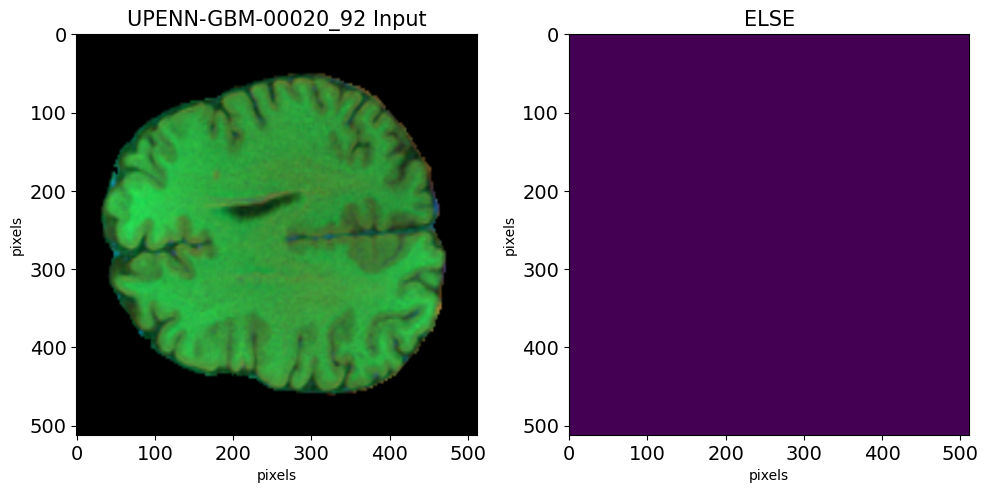

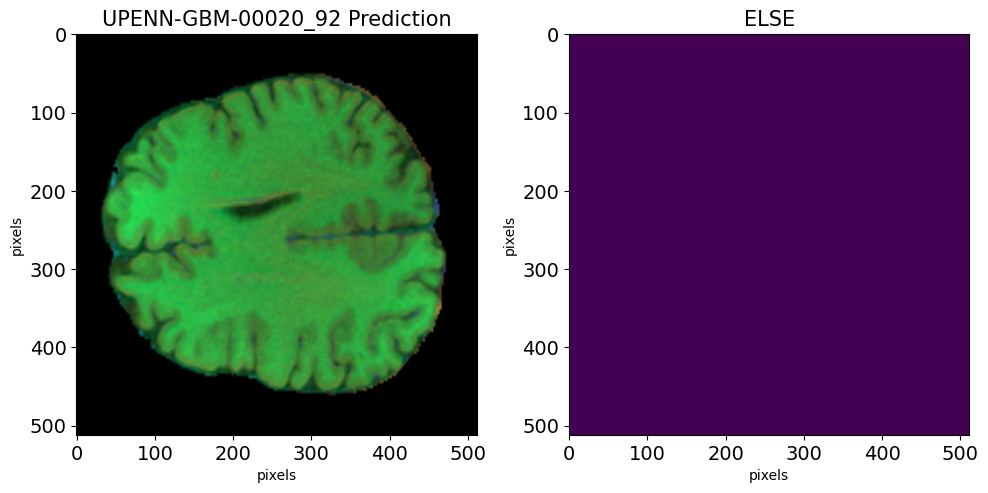

In [ ]:
# visual QC predicted masks

# plot input mask labels
plot_mask_labels(class_labels= test_class_labels.numpy(),
             pixel_values = test_image.numpy(),
             mask_labels = test_mask_labels,
             title= test_subj + " Input")

# plot predicted mask labels
pred_class_labels = set([item["label_id"] for item in results['segments_info']])
pred_class_labels = sorted(list(pred_class_labels))


pred_mask_labels = get_mask_from_segm(infer_results=results, data_id=test_subj)
plot_mask_labels(class_labels=pred_class_labels,
             pixel_values = test_image.numpy(),
             mask_labels = pred_mask_labels,
             title= test_subj + " Prediction")


In [ ]:
print("test_mask_labels", test_mask_labels.shape)
print("pred_mask_labels", pred_mask_labels.shape)

test_mask_labels torch.Size([1, 512, 512])
pred_mask_labels (1, 512, 512)


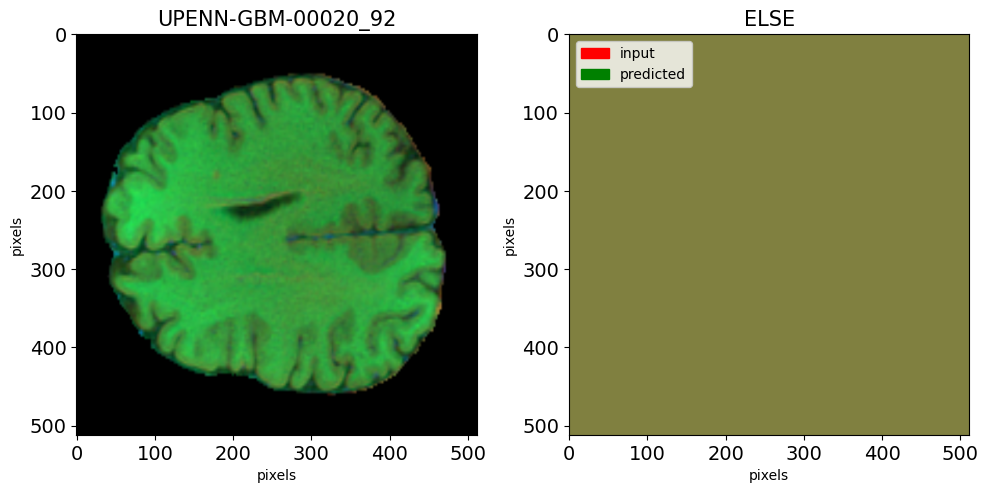

In [ ]:
plot_mask_comparison(class_labels=test_class_labels.numpy(),
             input_pixel_values=test_image.numpy(),
             input_mask_labels=test_mask_labels,
             pred_mask_labels=pred_mask_labels,
             title=test_subj)

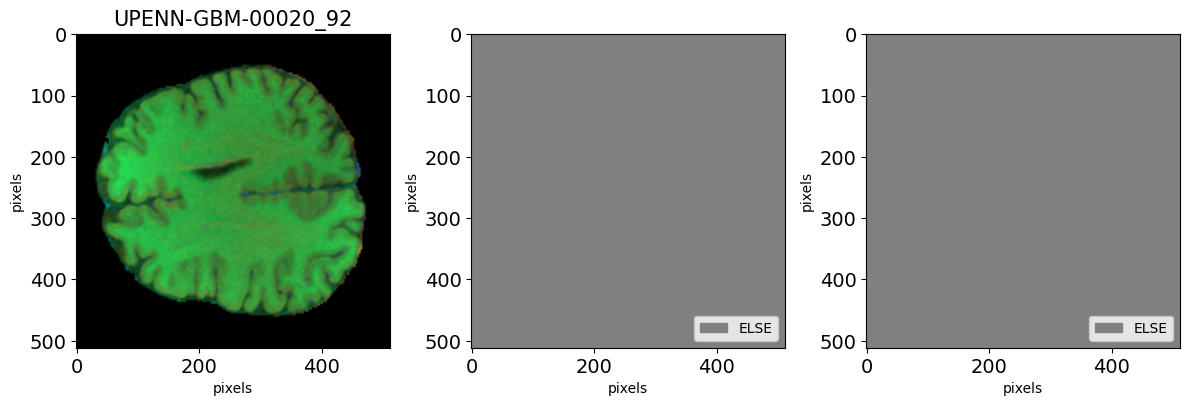

In [ ]:
input_segmentation = input_mask_to_segmentation(input_mask_labels=test_mask_labels, class_labels=label_ids)
pred_segmentation = pred_mask_to_segmentation(results)

plot_segmentation_comparison(
            input_pixel_values=test_image.numpy(),
            input_segmentation=input_segmentation.astype(np.uint8),
            pred_segmentation=pred_segmentation,
            title=test_subj)

#### 4.1.2 Visualization of model output (Optional)

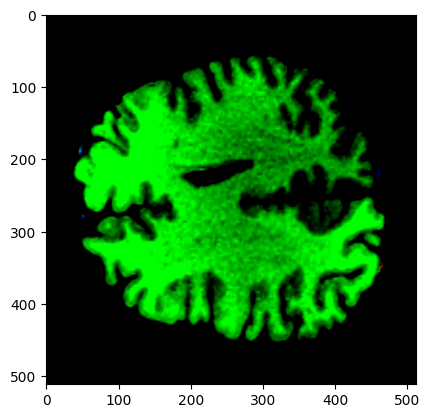

In [ ]:
# display first image
input_image = test_image.permute(1,2,0).numpy()
plt.imshow(input_image)
plt.show()

In [ ]:
# print information on the output
print('output keys:',outputs.keys())

print('class_queries_logits shape:',outputs.class_queries_logits.shape)
print('masks_queries_logits shape:',outputs.masks_queries_logits.shape)

print('encoder_last_hidden_state shape:',outputs.encoder_last_hidden_state.shape)
print('pixel_decoder_last_hidden_state shape:',outputs.pixel_decoder_last_hidden_state.shape)
print('transformer_decoder_last_hidden_state shape:',outputs.transformer_decoder_last_hidden_state.shape)

print('len(attentions):',len(outputs.attentions))
print('attentions[0]:',outputs.attentions[0].shape)


output keys: odict_keys(['loss', 'class_queries_logits', 'masks_queries_logits', 'encoder_last_hidden_state', 'pixel_decoder_last_hidden_state', 'transformer_decoder_last_hidden_state', 'attentions'])
class_queries_logits shape: torch.Size([1, 100, 5])
masks_queries_logits shape: torch.Size([1, 100, 128, 128])
encoder_last_hidden_state shape: torch.Size([1, 1024, 16, 16])
pixel_decoder_last_hidden_state shape: torch.Size([1, 256, 128, 128])
transformer_decoder_last_hidden_state shape: torch.Size([1, 100, 256])
len(attentions): 6
attentions[0]: torch.Size([1, 8, 100, 100])


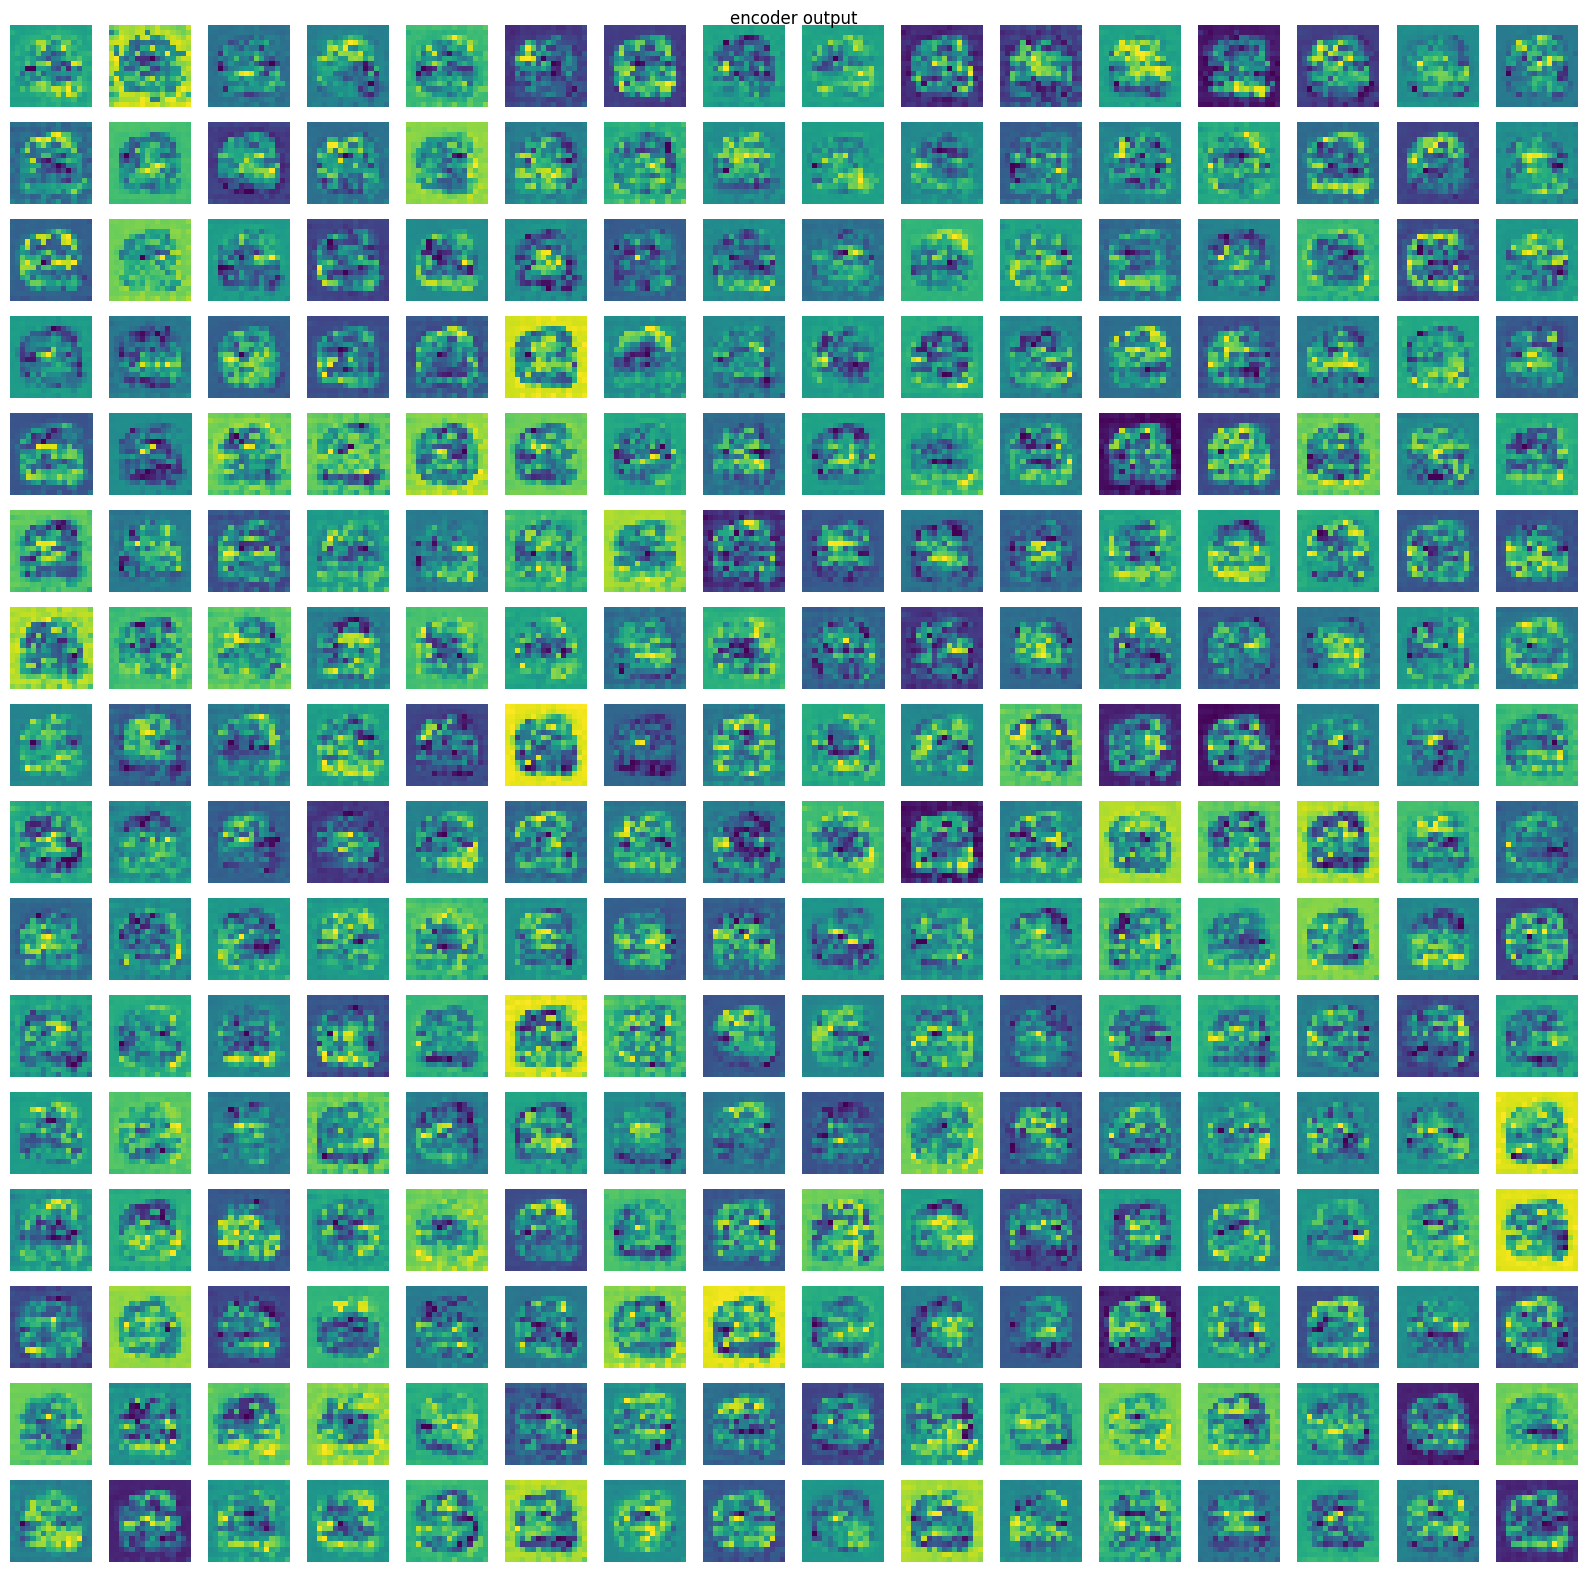

In [ ]:
# visualize the last layer of the encoder

n_row = 32
n_col = 32
n_skip = 2

fig, axs = plt.subplots(nrows=n_row//n_skip, ncols=n_col//n_skip,
                        figsize=(n_col//n_skip, n_row//n_skip))

for irow in range(n_row//n_skip):
    for icol in range(n_col//n_skip):
        idx = (irow*n_skip) * n_col + icol*n_skip
        encoder_last_hidden_state = outputs.encoder_last_hidden_state[0,idx,:,:].detach().cpu().numpy()
        axs[irow,icol].imshow(encoder_last_hidden_state)
        axs[irow,icol].axis('off')

fig.suptitle('encoder output')
fig.tight_layout()
fig.show()

In [ ]:
# visualize the last layer of the pixel decodeer
n_row = 16
n_col = 16

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(n_col, n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        idx = irow * n_col + icol
        encoder_last_hidden_state = outputs.pixel_decoder_last_hidden_state[0,idx,:,:].detach().cpu().numpy()
        axs[irow,icol].imshow(encoder_last_hidden_state)
        axs[irow,icol].axis('off')

fig.suptitle('pixel_decoder output')
fig.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

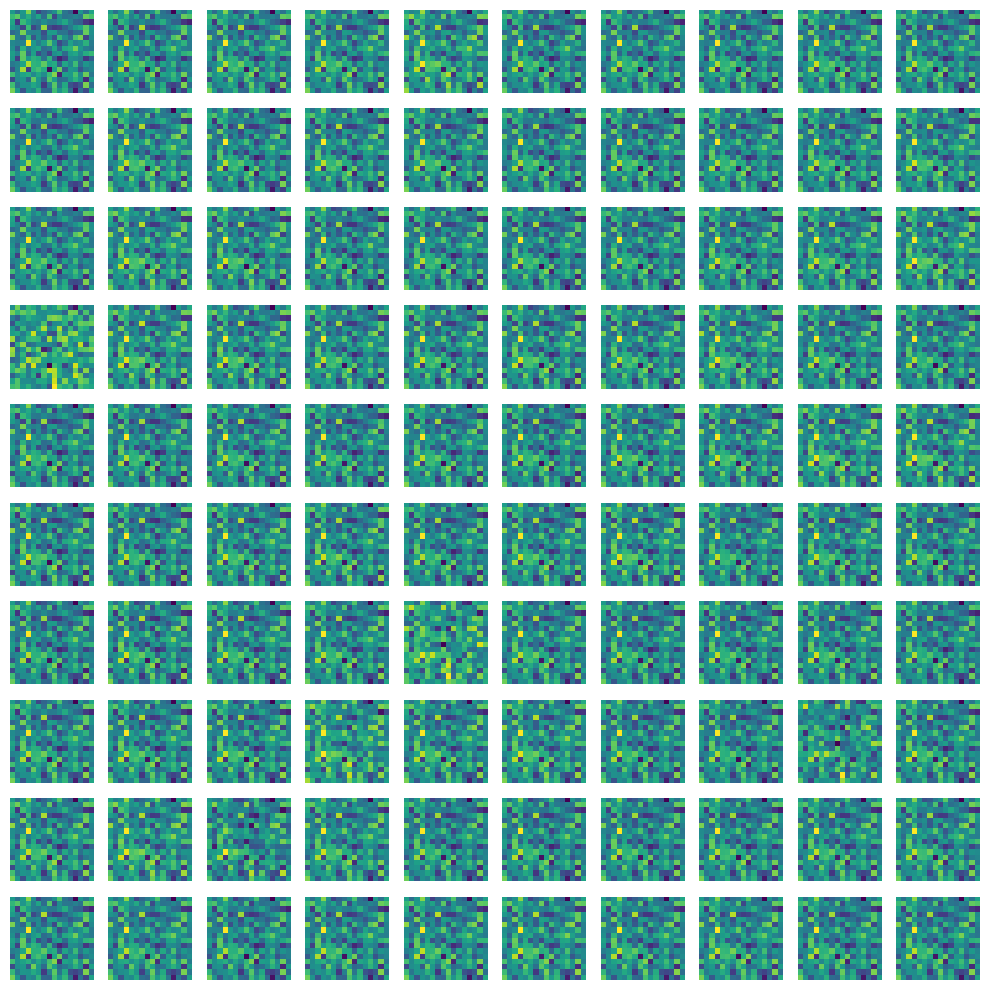

In [ ]:
# visualize the last layer of the transformer decodeer

n_row = 10
n_col = 10

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(n_col, n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        idx = irow * n_col + icol
        decoder_last_test =  outputs.transformer_decoder_last_hidden_state[0,idx,:].detach().cpu().numpy().reshape((16,16))
        axs[irow,icol].imshow(decoder_last_test)
        axs[irow,icol].axis('off')

fig.tight_layout()
fig.show()

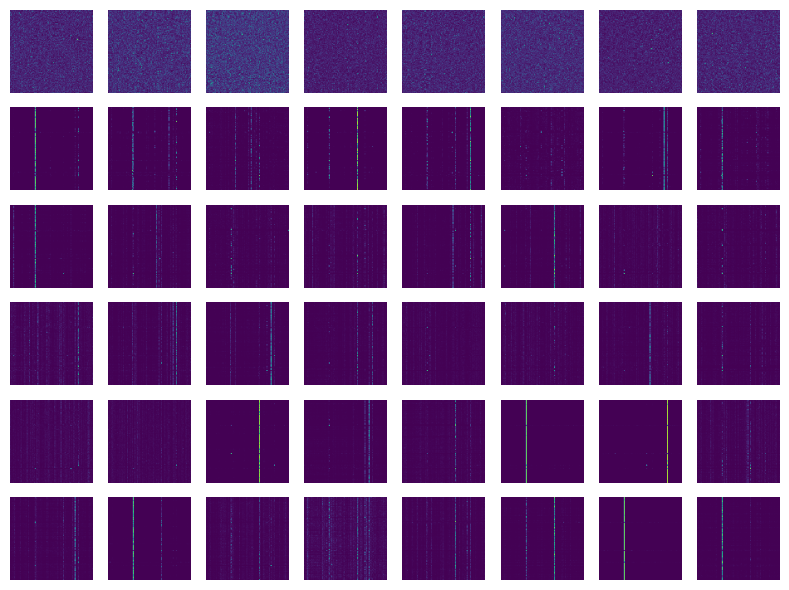

In [ ]:
# visualize the attention map

n_row = 6
n_col = 8

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(n_col, n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        attention_test = outputs.attentions[irow][0,icol,:,:].squeeze().detach().cpu().numpy()
        axs[irow,icol].imshow(attention_test)
        axs[irow,icol].axis('off')

fig.tight_layout()
fig.show()

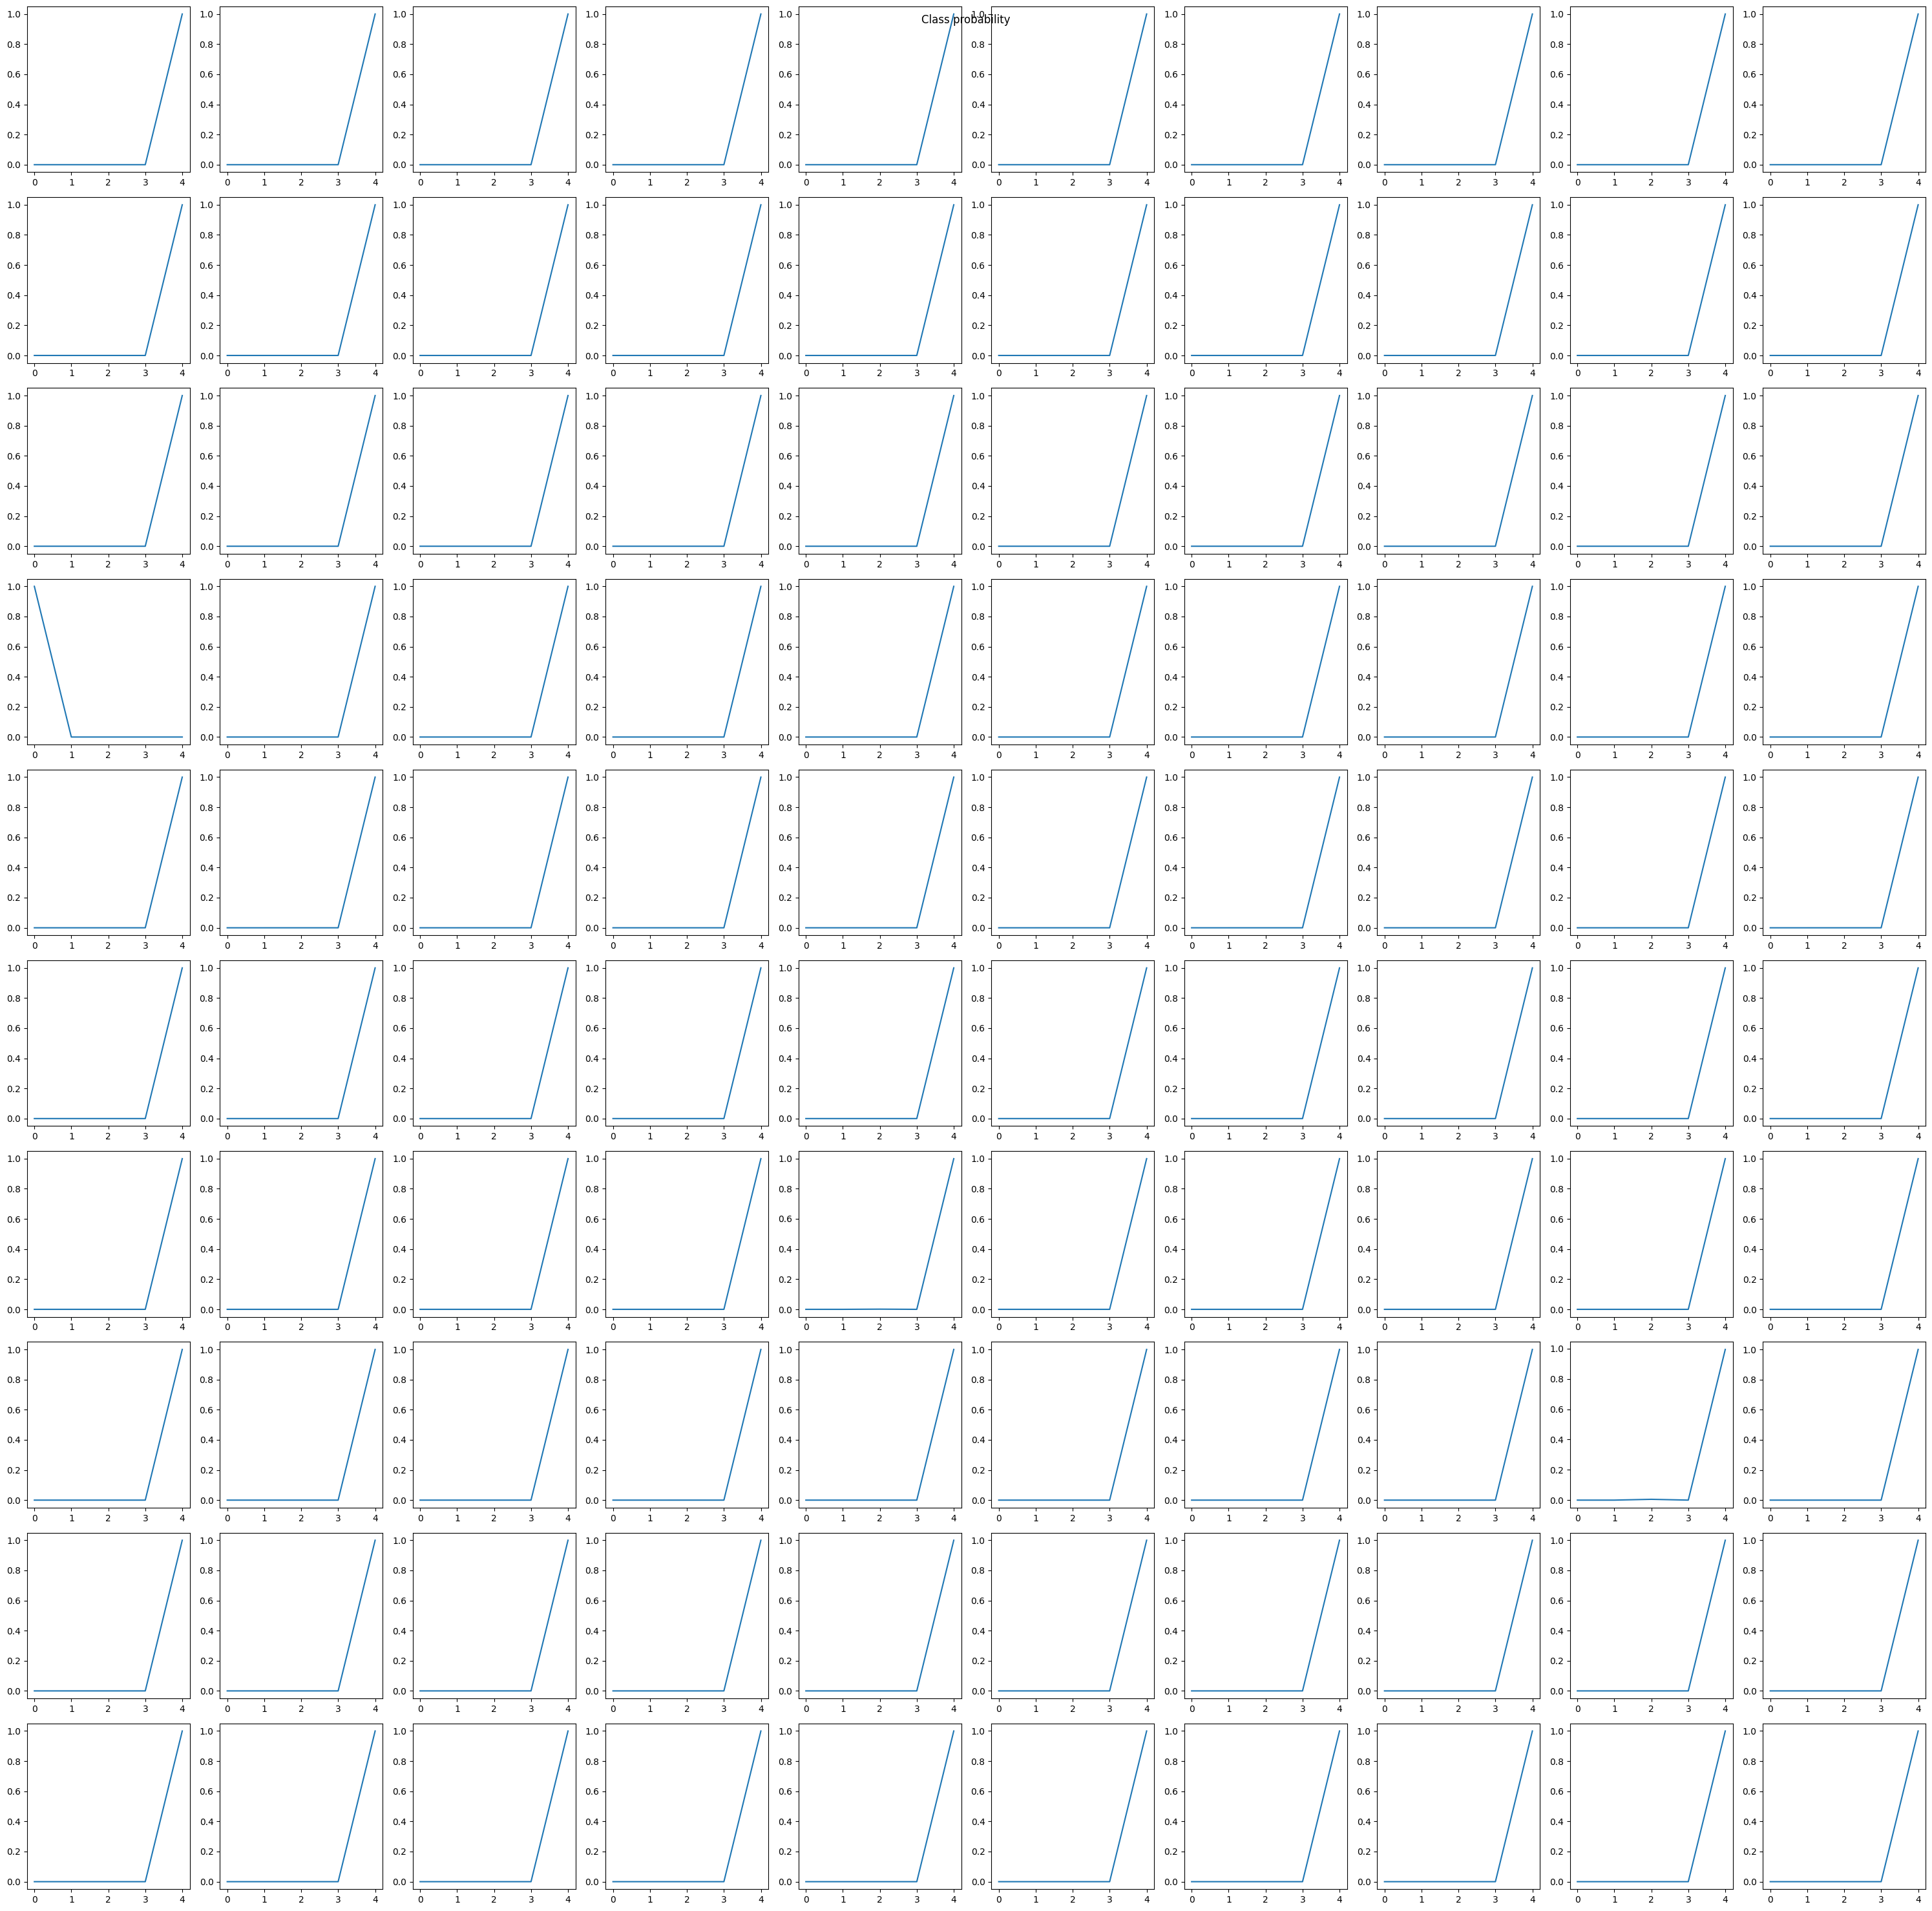

In [ ]:
# compute and visualize class probability prediction

n_row = 10
n_col = 10

class_probs = np.zeros((outputs.class_queries_logits.shape[1], outputs.class_queries_logits.shape[2]))

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(3*n_col, 3*n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        idx = irow*n_col+icol
        class_queries_logits_test = outputs.class_queries_logits[0,idx,:].squeeze().detach().cpu().numpy()

        class_probs[idx,:] = softmax(class_queries_logits_test)

        axs[irow,icol].plot(class_probs[idx,:])
        # axs[irow,icol].axis('off')

fig.suptitle('Class probability')
fig.tight_layout()
fig.show()

In [ ]:
# compute mask prediction from pixel decoder and transofmrer decoder
# it is a dot product reducing the channel dimmension followed by a sigmoind activation

img_size = outputs.pixel_decoder_last_hidden_state.shape[-1]

# Reshape array1 for matrix multiplication
pixel_decoder_reshaped = outputs.pixel_decoder_last_hidden_state[0,:,:,:].squeeze().detach().cpu().reshape(256, img_size*img_size)
transformer_decoder_reshaped = outputs.transformer_decoder_last_hidden_state[0,:,:].squeeze().detach().cpu().reshape(100, 256)

# Perform matrix multiplication
mask_pred_vis = torch.matmul(transformer_decoder_reshaped, pixel_decoder_reshaped)

# Apply sigmoid function
mask_pred_vis = torch.sigmoid(mask_pred_vis)

# Reshape result to the desired shape
mask_pred_vis = mask_pred_vis.reshape(100, img_size, img_size).numpy()

mask_pred_vis.shape

(100, 128, 128)

In [ ]:
print(pixel_decoder_reshaped.shape)
print(transformer_decoder_reshaped.shape)

torch.Size([256, 16384])
torch.Size([100, 256])


In [ ]:
# visualize mask prediction

n_row = 10
n_col = 10

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(3*n_col, 3*n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        idx = irow*n_col+icol

        img = axs[irow,icol].imshow(mask_pred_vis[idx,:,:])
        axs[irow,icol].axis('off')
        fig.colorbar(img, ax=axs[irow,icol])

fig.suptitle('Mask pred')
fig.tight_layout()
fig.show()


In [ ]:
print('shape of class probability is:',class_probs.shape)
print('shape of predicted mask is:', mask_pred_vis[0,:,:].shape)

In [ ]:
# Reshape array1 for matrix multiplication
class_probs_tensor = torch.from_numpy(class_probs).double()
mask_pred_tensor = torch.from_numpy(mask_pred_vis).double()

matrix1 = class_probs_tensor.permute(1, 0)
matrix2 = mask_pred_tensor.reshape(100, img_size*img_size)

matrix_out = torch.matmul(matrix1, matrix2).reshape(5,img_size,img_size)

result = torch.argmax(matrix_out[:-1,:,:], dim=0)

print(result.shape)

plt.imshow(result)
plt.colorbar()
plt.show()

In [ ]:
input_image = test_image.permute(1,2,0).numpy()
plt.imshow(input_image)
plt.show()

#### 4.1.3 Calcualte metrics on one sample

In [ ]:
print("True mask label", test_mask_labels.numpy().shape)
print("Pred mask label", pred_mask_labels.shape)

In [ ]:
for label_id in test_class_labels.numpy():

    print(f"Metrics for {id2label[label_id]}:")
    true_mask = test_mask_labels[label_id, :, :].numpy().squeeze().astype(np.uint8)

    pred_visual_mask = pred_mask_labels[label_id, :, :].squeeze()
    pred_mask = (np.array(pred_visual_mask)/255).astype(np.uint8)

    other_metrics = metrics.calc_binary_metrics(pred_mask, true_mask)

    print("Specificity", other_metrics["specificity"])
    print("Sensitivity", other_metrics["sensitivity"])
    print("Precision", other_metrics["precision"])
    print("Recall", other_metrics["recall"])

    dice_score = metrics.calc_dice_score(pred_mask, true_mask)
    print("Dice Score", dice_score)

    hd95 = metrics.calc_hausdorff_95(pred_mask, true_mask)
    print("HD95", hd95)
    print()

### 4.2 Make predictions on all data and compute metrics

#### 4.2.1 Obtain data list for all data being tested

In [ ]:
# construct the unique list of slices from val 2d
# val_2d: UPENN-GBM-00006_11_FLAIR_1.nii.gz, UPENN-GBM-00006_11_T1_1.nii.gz, UPENN-GBM-00006_11_FLAIR_2.nii.gz...
# unique slices per subj: UPENN-GBM-00006_1.nii.gz, UPENN-GBM-00006_2.nii.gz
val_files = list(set([data_handler.get_mri_slice_file_name(val_file) for val_file in val_2d]))
val_files[:10]

In [ ]:
# get unique subj_ids
val_subjs = [data_handler.get_mri_subj(val_file) for val_file in val_files]
val_subjs = sorted(list(set(val_subjs)))

print("total validation data", len(val_subjs))
print("first 10")
val_subjs[:10]

#### 4.2.2 Predict Validation Data

In [ ]:
print("val metrics_file_name: ", val_metrics_file_name)

val_metrics_dict, val_error_files, val_success_files = predict_and_eval(val_files, val_subjs,
                                                                        metrics_dir_prefix=metrics_dir_prefix,
                                                                        metrics_file_name=val_metrics_file_name,
                                                                        recalculate=RECALCULATE_VAL_METRICS)

#### 4.2.3 Evaluate Validation Data

##### Summary statistics

In [ ]:
for key, np_val in val_metrics_dict.items():
    display_statistics(np_val, key, all_label_names)
    print("\n")

##### Box plots

In [ ]:
draw_box_plots(val_metrics_dict)

##### Histograms

In [ ]:
build_histogram(val_metrics_dict)

##### Worst dice score and hd95

In [ ]:
low_dice_score_val = get_low_dice_score_images(val_subjs, val_metrics_dict, top_n=10)
low_dice_score_val

In [ ]:
high_hd95_val = get_high_hd95_images(val_subjs, val_metrics_dict, top_n=10)
high_hd95_val

visualize image with low dice score

1st image

In [ ]:
# get image with worst dice score
vol_slices_list = get_2d_slices(val_files, low_dice_score_val.loc[0]['subj_name'])
image_3d, mask_true_3d, mask_pred_3d = predict_3d_mask(model, data_handler, vol_slices_list,
                                                            processor, train_transform, MriType.VAL_2D)

# check shapes
print("image_3d", image_3d.shape)
print("mask_true_3d", mask_true_3d.shape)
print("mask_pred_3d", mask_pred_3d.shape)

In [ ]:
# plot
slice_idx = int(mask_true_3d.shape[1]//2)
plot_mask_comparison(class_labels=label_ids,
             input_pixel_values = image_3d[slice_idx, :, :, :].squeeze(),
             input_mask_labels = mask_true_3d[:, slice_idx, :, :].squeeze(),
             pred_mask_labels = mask_pred_3d[:, slice_idx, :, :].squeeze(),
             title="prediction")

2nd image

In [ ]:
# get image with worst dice score
vol_slices_list = get_2d_slices(val_files, low_dice_score_val.loc[1]['subj_name'])
image_3d_top2, mask_true_3d_top2, mask_pred_3d_top2 = predict_3d_mask(model, data_handler, vol_slices_list,
                                                            processor, train_transform, MriType.VAL_2D)

In [ ]:
# plot
slice_idx = int(mask_true_3d.shape[1]//2)
plot_mask_comparison(class_labels=label_ids,
             input_pixel_values = image_3d_top2[slice_idx, :, :, :].squeeze(),
             input_mask_labels = mask_true_3d_top2[:, slice_idx, :, :].squeeze(),
             pred_mask_labels = mask_pred_3d_top2[:, slice_idx, :, :].squeeze(),
             title=test_subj)

##### QC 3D volume by slicing in 3 directions (optional)

will review and fix

In [ ]:
# n_image = len(id2label)+1
# id_list = list(id2label.keys())
# id_list.sort()

# slice_no = 60

# fig, axs = plt.subplots(nrows=2, ncols=n_image, figsize=(3*n_image, 3*2))  # Create subplots grid

# mask_pred = np.zeros((len(id_list)))

# for mask_idx, id in enumerate(id_list):
#     mask_cur = mask_true_3d[mask_idx, slice_no,:,:]
#     img = Image.fromarray(mask_cur)

#     im = axs[0,mask_idx+1].imshow(img)
#     axs[0,mask_idx+1].set_title(f"{id2label[id]}")  # Set a title for the subplot
#     cbar = fig.colorbar(im, ax=axs[0, mask_idx + 1], pad=0.05, fraction=0.05)

#     label = id2label[id]
#     print("Visualizing mask for instance:", label)
#     print("label_id is:", id )

#     mask_cur = mask_pred_3d[mask_idx, slice_no,:,:]

#     im = axs[1,mask_idx+1].imshow(mask_cur)
#     axs[1,mask_idx+1].set_title(f"{label}")  # Set a title for the subplot
#     cbar = fig.colorbar(im, ax=axs[1, mask_idx + 1], pad=0.05, fraction=0.05)

# unnormalized_image = ( image_3d[slice_no,:,:,:] * np.array(ADE_STD)[:, None, None] ) + np.array(ADE_MEAN)[:, None, None]
# unnormalized_image = ( unnormalized_image * 255 ).astype(np.uint8)
# unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)

# axs[0,0].imshow(unnormalized_image)
# # axs[0,0].set_title(f"{success_val_files[-1]}")

# axs[1,0].imshow(unnormalized_image)
# axs[1,0].set_title(f"Image")

# plt.tight_layout()
# plt.show()

#### 4.2.4 Obtain data list for all training data

In [ ]:
# Create a new list of files from the full train list dataset
train_files = list(set([data_handler.get_mri_slice_file_name(train_file) for train_file in train_2d]))
train_files[:10]

In [ ]:
# get unique subj_ids
train_subjs = [data_handler.get_mri_subj(train_file) for train_file in train_files]
train_subjs = sorted(list(set(train_subjs)))

print("total training data", len(train_subjs))

print("first 10")
train_subjs[:10]

#### 4.2.5. Predict Training Data

In [ ]:
print("train metrics_file_name: ", train_metrics_file_name)
train_metrics_dict, train_error_files, train_success_files = predict_and_eval(train_files, train_subjs,
                                                                        metrics_dir_prefix=metrics_dir_prefix,
                                                                        metrics_file_name=train_metrics_file_name,
                                                                        data_identifier=MriType.TRAIN_2D,
                                                                        recalculate=RECALCULATE_TRAIN_METRICS)

train metrics_file_name:  metrics_train_all_aug_20epoch_jul14.joblib
Calculating metrics for  UPENN-GBM-00006
Calculating metrics for  UPENN-GBM-00009
Calculating metrics for  UPENN-GBM-00011
Calculating metrics for  UPENN-GBM-00016
Calculating metrics for  UPENN-GBM-00017
Calculating metrics for  UPENN-GBM-00018
Calculating metrics for  UPENN-GBM-00021
Calculating metrics for  UPENN-GBM-00029
Calculating metrics for  UPENN-GBM-00031
Calculating metrics for  UPENN-GBM-00035
Calculating metrics for  UPENN-GBM-00040
Calculating metrics for  UPENN-GBM-00041
Calculating metrics for  UPENN-GBM-00043
Calculating metrics for  UPENN-GBM-00060
Calculating metrics for  UPENN-GBM-00066
Calculating metrics for  UPENN-GBM-00069
Calculating metrics for  UPENN-GBM-00073
Calculating metrics for  UPENN-GBM-00076
Calculating metrics for  UPENN-GBM-00080
Calculating metrics for  UPENN-GBM-00082
Calculating metrics for  UPENN-GBM-00083
Calculating metrics for  UPENN-GBM-00088
Calculating metrics for  UPEN


#### 4.2.6 Evaluate Training Data

##### Summary statistics

In [ ]:
for key, np_val in train_metrics_dict.items():
    display_statistics(np_val, key, all_label_names)
    print("\n")

Summary: precision
            ELSE        NCR         ED         ET
count  88.000000  88.000000  88.000000  88.000000
mean    0.999535   0.794512   0.878596   0.849308
std     0.000259   0.161321   0.077743   0.059619
min     0.998673   0.000000   0.523367   0.637844
25%     0.999434   0.754077   0.856231   0.816850
50%     0.999566   0.832695   0.893894   0.861018
75%     0.999707   0.904702   0.930325   0.887587
max     0.999944   0.960183   0.961559   0.972158


Summary: recall
            ELSE        NCR         ED         ET
count  88.000000  88.000000  88.000000  88.000000
mean    0.997428   0.784475   0.869389   0.827717
std     0.001303   0.121773   0.056618   0.058030
min     0.993479   0.000000   0.557622   0.607696
25%     0.996592   0.750183   0.850049   0.799731
50%     0.997767   0.808702   0.879476   0.840037
75%     0.998324   0.849172   0.904757   0.867405
max     0.999453   0.933481   0.936820   0.918452


Summary: sensitivity
            ELSE        NCR         ED  

##### Box plots

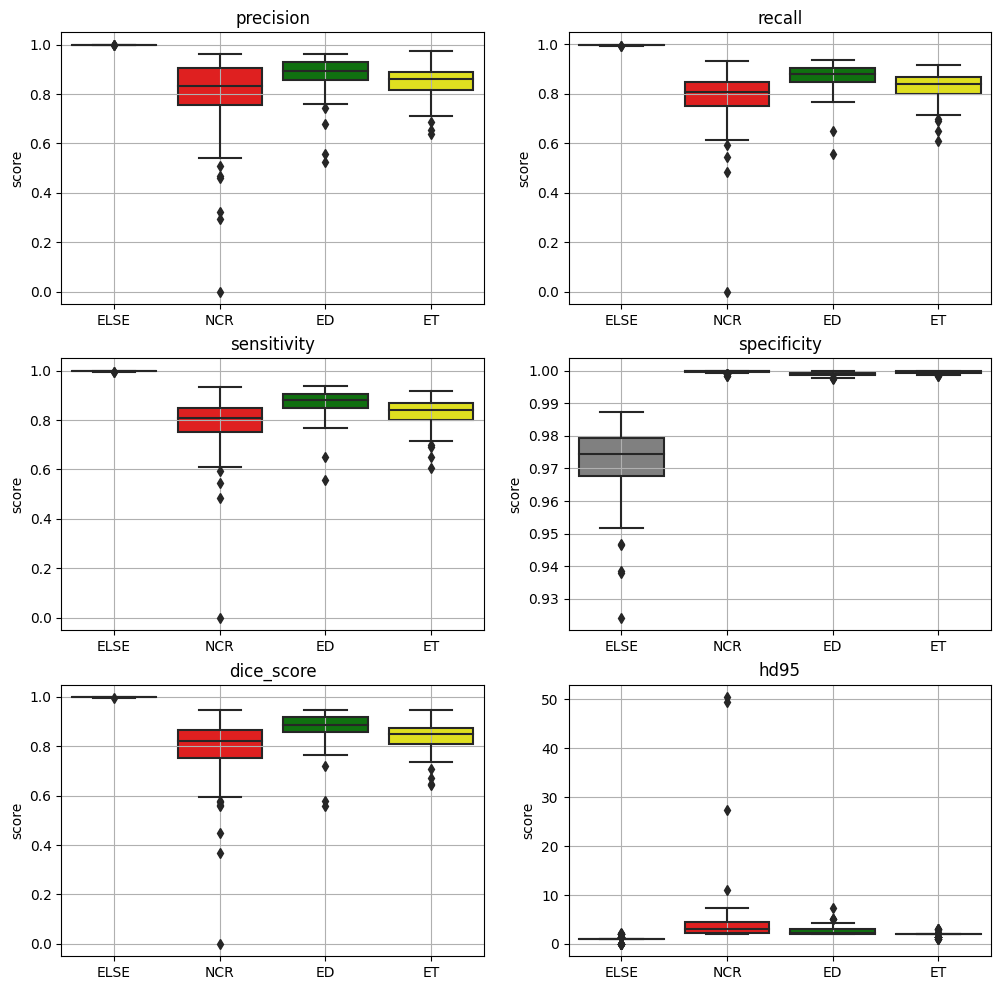

In [ ]:
draw_box_plots(train_metrics_dict)

##### Histograms

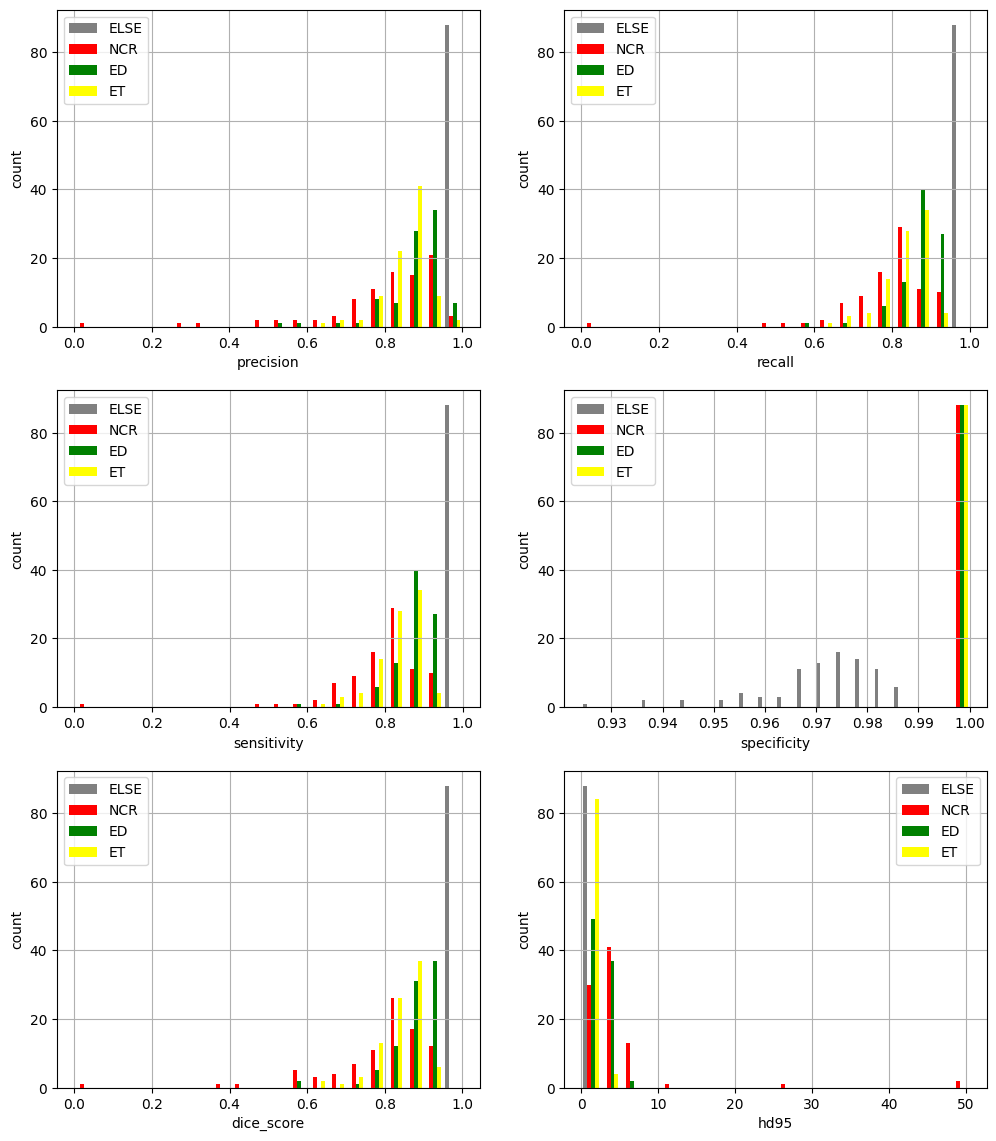

In [ ]:
build_histogram(train_metrics_dict)

##### Worst dice score and hd95

In [ ]:
low_dice_score_train = get_low_dice_score_images(train_subjs, train_metrics_dict, top_n=10)
low_dice_score_train

,subj_name,dataset_idx,label_id,score
0,UPENN-GBM-00178,48,1,0.000000
1,UPENN-GBM-00393,80,1,0.367669
2,UPENN-GBM-00096,24,1,0.448451
3,UPENN-GBM-00176,47,2,0.558452
4,UPENN-GBM-00029,7,1,0.560087
5,UPENN-GBM-00043,12,1,0.561870
6,UPENN-GBM-00262,60,1,0.575087
7,UPENN-GBM-00148,41,1,0.578992
8,UPENN-GBM-00388,77,2,0.580104
9,UPENN-GBM-00189,50,1,0.592548


### Plot Low Dice Score Images


In [ ]:
low_hd95_train = get_high_hd95_images(train_subjs, train_metrics_dict, top_n=10)
low_hd95_train

,subj_name,dataset_idx,label_id,score
0,UPENN-GBM-00178,48,1,50.497475
1,UPENN-GBM-00174,46,1,49.497475
2,UPENN-GBM-00393,80,1,27.297266
3,UPENN-GBM-00009,1,1,11.000000
4,UPENN-GBM-00041,11,1,7.348469
5,UPENN-GBM-00388,77,2,7.280110
6,UPENN-GBM-00011,2,1,7.280110
7,UPENN-GBM-00112,28,1,6.480741
8,UPENN-GBM-00391,79,1,6.324555
9,UPENN-GBM-00091,22,1,6.000000
